<a href="https://colab.research.google.com/github/mzhirko/anomaly-detection-metrics-comparison/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import random
from datetime import datetime
import json
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shuthdar/global-surface-temperature-anomalies-time-series -p ./data
!kaggle datasets download -d sid321axn/beijing-multisite-airquality-data-set -p ./data

!unzip -q ./data/global-surface-temperature-anomalies-time-series.zip -d ./data/temp_anomaly
!unzip -q ./data/beijing-multisite-airquality-data-set.zip -d ./data/beijing_air

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shuthdar/global-surface-temperature-anomalies-time-series
License(s): CC0-1.0
  0% 0.00/1.32k [00:00<?, ?B/s]
100% 1.32k/1.32k [00:00<00:00, 4.24MB/s]
Dataset URL: https://www.kaggle.com/datasets/sid321axn/beijing-multisite-airquality-data-set
License(s): other
 82% 7.00M/8.58M [00:01<00:00, 8.35MB/s]
100% 8.58M/8.58M [00:01<00:00, 5.98MB/s]


In [4]:
import glob

def load_beijing_data():
    path = './data/beijing_air'
    all_files = glob.glob(path + "/*.csv")

    dfs = []
    for filename in all_files:
        df = pd.read_csv(filename)
        print(f"\nFile: {filename}")
        print("Shape:", df.shape)
        print("\nColumns:", df.columns.tolist())
        print("\nSample data:")
        print(df.head())
        dfs.append(df)

    return pd.concat(dfs, axis=0, ignore_index=True)

In [5]:
beijing_df = load_beijing_data()


File: ./data/beijing_air/PRSA_Data_Dingling_20130301-20170228.csv
Shape: (35064, 18)

Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

Sample data:
   No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1020.8 -19.7   0.0    E   0.5  Dingling  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  1022.3 -19.4   0.0    N   2.1  Dingling  

File: ./data/beijing_air/PRSA

In [6]:
def load_temperature_data():
    df = pd.read_csv('./data/temp_anomaly/temp_anomaly.csv')
    print("\nTemperature Anomaly Dataset:")
    print("Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nSample data:")
    print(df.head())
    return df

In [7]:
temp_df = load_temperature_data()


Temperature Anomaly Dataset:
Shape: (174, 4)

Columns: ['Year', 'AnomalyBoth', 'AnomalyLand', 'AnomalyOcean']

Sample data:
   Year  AnomalyBoth  AnomalyLand  AnomalyOcean
0  1850        -0.17        -0.42         -0.06
1  1851        -0.09        -0.29          0.00
2  1852        -0.10        -0.39          0.03
3  1853        -0.12        -0.40          0.01
4  1854        -0.11        -0.32         -0.02


In [8]:
import glob
import pandas as pd

!rm -rf NAB
!git clone https://github.com/numenta/NAB.git

!pip install Cython==0.29.14 pandas==0.23.3 boto3==1.9.134 simplejson==3.11.1 plotly==2.0.0 scikit-learn==0.21.1

import sys
sys.path.append('NAB')


Cloning into 'NAB'...
remote: Enumerating objects: 7119, done.
remote: Counting objects: 100% (713/713), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 7119 (delta 561), reused 519 (delta 504), pack-reused 6406 (from 1)
Receiving objects: 100% (7119/7119), 86.76 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (4984/4984), done.
Updating files: 100% (1186/1186), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [9]:
import os

# List all files in the NAB/data directory
data_dir = 'NAB/data'
for root, dirs, files in os.walk(data_dir):
    for file in files:
        print(os.path.join(root, file))


NAB/data/README.md
NAB/data/realTraffic/speed_t4013.csv
NAB/data/realTraffic/speed_6005.csv
NAB/data/realTraffic/TravelTime_387.csv
NAB/data/realTraffic/occupancy_6005.csv
NAB/data/realTraffic/TravelTime_451.csv
NAB/data/realTraffic/occupancy_t4013.csv
NAB/data/realTraffic/speed_7578.csv
NAB/data/realAdExchange/exchange-3_cpc_results.csv
NAB/data/realAdExchange/exchange-2_cpm_results.csv
NAB/data/realAdExchange/exchange-3_cpm_results.csv
NAB/data/realAdExchange/exchange-2_cpc_results.csv
NAB/data/realAdExchange/exchange-4_cpm_results.csv
NAB/data/realAdExchange/exchange-4_cpc_results.csv
NAB/data/realTweets/Twitter_volume_KO.csv
NAB/data/realTweets/Twitter_volume_AAPL.csv
NAB/data/realTweets/Twitter_volume_UPS.csv
NAB/data/realTweets/Twitter_volume_GOOG.csv
NAB/data/realTweets/Twitter_volume_AMZN.csv
NAB/data/realTweets/Twitter_volume_FB.csv
NAB/data/realTweets/Twitter_volume_CVS.csv
NAB/data/realTweets/Twitter_volume_IBM.csv
NAB/data/realTweets/Twitter_volume_PFE.csv
NAB/data/realTwee

In [42]:
class LSTMAnomalyDetector:
    def __init__(self, time_steps=50):
        self.time_steps = time_steps
        self.model = None
        self.scaler = StandardScaler()
        self.threshold = None

    def create_sequences(self, values):
        output = []
        for i in range(len(values) - self.time_steps):
            output.append(values[i:(i + self.time_steps)])
        return np.stack(output) if len(output) > 0 else np.array([])

    def build_model(self):
        inputs = Input(shape=(self.time_steps, 1))
        x = BatchNormalization()(inputs)
        x = LSTM(64, activation='tanh', return_sequences=True, kernel_initializer='glorot_normal')(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        x = LSTM(32, activation='tanh', return_sequences=False)(x)
        x = Dropout(0.2)(x)
        x = RepeatVector(self.time_steps)(x)
        x = BatchNormalization()(x)
        x = LSTM(32, activation='tanh', return_sequences=True)(x)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        x = LSTM(64, activation='tanh', return_sequences=True)(x)
        x = Dropout(0.2)(x)
        outputs = TimeDistributed(Dense(1))(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
                      loss='huber')
        return model

    def fit_predict(self, data, value_col, verbose=1):
        data = data.copy()
        data[value_col] = pd.to_numeric(data[value_col], errors='coerce')
        data = data.dropna(subset=[value_col]).copy()  # Ensure no NaNs remain

        print(f"Value range for {value_col}: min={data[value_col].min()}, max={data[value_col].max()}")

        values = self.scaler.fit_transform(data[value_col].values.reshape(-1, 1))
        print("NaNs after scaling:", np.isnan(values).sum())
        print("Infs after scaling:", np.isinf(values).sum())
        print("Scaled data range:", values.min(), values.max())

        X = self.create_sequences(values)
        if X.size == 0:
            raise ValueError("No sequences were created. Check if time_steps is appropriate or if the dataset is too short.")

        X = X.reshape((X.shape[0], X.shape[1], 1))

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
        ]

        self.model = self.build_model()
        history = self.model.fit(
            X, X,
            epochs=50,
            batch_size=64,
            validation_split=0.1,
            callbacks=callbacks,
            shuffle=False,
            verbose=verbose
        )

        X_pred = self.model.predict(X, verbose=0)
        if np.isnan(X_pred).any():
            raise ValueError("NaNs encountered in model predictions. Check data and model configuration.")

        mae_loss = np.mean(np.abs(X_pred - X), axis=(1, 2))
        self.threshold = np.percentile(mae_loss, 95)
        anomalies = (mae_loss > self.threshold).astype(int)

        # Initialize 'lstm_anomaly' with 0s and 'mae_loss' with 0.0
        data['lstm_anomaly'] = 0
        data['mae_loss'] = 0.0

        # Assign anomalies and mae_loss starting from time_steps index
        data.iloc[self.time_steps:self.time_steps + len(anomalies), data.columns.get_loc('lstm_anomaly')] = anomalies
        data.iloc[self.time_steps:self.time_steps + len(mae_loss), data.columns.get_loc('mae_loss')] = mae_loss

        return anomalies, history.history, data


In [43]:
def plot_lstm_anomalies(data, timestamp_col, value_col, title):
    detector = LSTMAnomalyDetector()

    plt.figure(figsize=(15, 6))
    plt.plot(data[timestamp_col], data[value_col], label='Data')

    try:
        predictions = detector.fit_predict(data[value_col])
        anomalies = data[predictions == 1]
        if len(anomalies) > 0:
            plt.scatter(anomalies[timestamp_col], anomalies[value_col],
                       color='red', label='LSTM Anomalies')

        plt.xlabel('Time')
        plt.ylabel(value_col)
        plt.title(f'LSTM Anomaly Detection - {title}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\nAnalysis for {title}:")
        print(f"Total points: {len(data)}")
        print(f"Detected anomalies: {len(anomalies)}")
        print(f"Anomaly rate: {len(anomalies)/len(data)*100:.2f}%")

    except Exception as e:
        print(f"Error processing {title}: {str(e)}")

In [67]:
def train_and_save_model(data, value_col, dataset_name):
    print(f"\nTraining model for {dataset_name}")
    os.makedirs('lstm_models', exist_ok=True)
    os.makedirs('training_history', exist_ok=True)

    detector = LSTMAnomalyDetector(time_steps=50)
    anomalies, history, data = detector.fit_predict(data, value_col)

    # Fill NaNs in 'lstm_anomaly' and 'mae_loss' with 0
    data['lstm_anomaly'] = data['lstm_anomaly'].fillna(0).astype(int)
    data['mae_loss'] = data['mae_loss'].fillna(method='ffill').fillna(0)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join('lstm_models', f'lstm_{dataset_name}_{timestamp}.h5')
    history_path = os.path.join('training_history', f'history_{dataset_name}_{timestamp}.json')

    detector.model.save(model_path)
    with open(history_path, 'w') as f:
        json.dump(history, f)

    # Plot training and validation loss
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    if max(history['loss']) != 0:
        train_acc = [1 - (x / max(history['loss'])) for x in history['loss']]
    else:
        train_acc = [1]*len(history['loss'])

    if max(history['val_loss']) != 0:
        val_acc = [1 - (x / max(history['val_loss'])) for x in history['val_loss']]
    else:
        val_acc = [1]*len(history['val_loss'])

    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Training Accuracy (pseudo)')
    plt.plot(val_acc, label='Validation Accuracy (pseudo)')
    plt.title(f'Model "Accuracy" - {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nTraining Summary for {dataset_name}:")
    print(f"Final training loss: {history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
    print(f"Model saved to: {model_path}")
    print(f"History saved to: {history_path}")
    print("LSTM Anomalies Recorded:")
    print(data['lstm_anomaly'].value_counts())

    return detector, history, data


## Beijing Air Quality Dataset

In [68]:
import glob

path = '/content/data/beijing_air'
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_temp)

df = pd.concat(li, axis=0, ignore_index=True)

# Rename columns
df.rename(columns={
    'PM2.5': 'pm2_5',
    'TEMP': 'temp',
    'PM10': 'pm10',
    'PRES': 'pressure',
    'DEWP': 'dewpointtemp',
    'RAIN': 'rain',
    'wd': 'wind_direction',
    'WSPM': 'windspeed_m_s'
}, inplace=True)

# Combine date and time columns into a datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop unnecessary columns
df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1, inplace=True)

# Handle missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Ensure no missing values remain
print(df.isnull().sum())


pm2_5             0
pm10              0
SO2               0
NO2               0
CO                0
O3                0
temp              0
pressure          0
dewpointtemp      0
rain              0
wind_direction    0
windspeed_m_s     0
station           0
dtype: int64


## Global Surface Temperature Anomalies Dataset

In [69]:
# Load the dataset
temperature_df = pd.read_csv('/content/data/temp_anomaly/temp_anomaly.csv')

# Convert 'Year' column to datetime
temperature_df['Year'] = pd.to_datetime(temperature_df['Year'], format='%Y')

# Set 'Year' as the index
temperature_df.set_index('Year', inplace=True)

# Rename columns for consistency
temperature_df.rename(columns={
    'Anomaly (deg C)': 'anomaly_global',
    'Anomaly_Land': 'anomaly_land',
    'Anomaly_Ocean': 'anomaly_ocean'
}, inplace=True)

# Handle missing values
temperature_df.interpolate(method='time', inplace=True)


## NAB

In [70]:
import pandas as pd
import glob
import os

# Process NAB datasets
nab_datasets = []
nab_path = 'NAB/data'

for root, dirs, files in os.walk(nab_path):
    for file in files:
        if file.endswith('.csv'):
            try:
                filepath = os.path.join(root, file)
                df_temp = pd.read_csv(filepath)

                df_temp['dataset'] = os.path.basename(filepath)
                df_temp['category'] = os.path.basename(os.path.dirname(filepath))

                df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])

                df_temp.set_index('timestamp', inplace=True)

                nab_datasets.append(df_temp)
            except Exception as e:
                print(f"Error processing {file}: {e}")

# Combine all datasets
nab_df = pd.concat(nab_datasets, axis=0)

# Handle missing values
nab_df.fillna(method='ffill', inplace=True)
nab_df.fillna(method='bfill', inplace=True)

# Print summary
print("Missing values after cleaning:")
print(nab_df.isnull().sum())
print("\nDataset categories:")
print(nab_df['category'].value_counts())

Missing values after cleaning:
value       0
dataset     0
category    0
dtype: int64

Dataset categories:
category
realTweets               158631
realKnownCause            69561
realAWSCloudwatch         67740
artificialWithAnomaly     24192
artificialNoAnomaly       20160
realTraffic               15664
realAdExchange             9610
Name: count, dtype: int64


Training Temperature Model...

Training model for temperature_dataset
Value range for AnomalyBoth: min=-0.44, max=1.18
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -1.392468613170942 3.195597461412636
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.3366 - val_loss: 0.6177 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3018 - val_loss: 0.6133 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2903 - val_loss: 0.6094 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2727 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2665 - val_loss: 0.6014 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2543 - val_loss: 0.5976 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2396 - val_loss: 0.5938 - learning_rate: 1.0000e-04
Epoch 

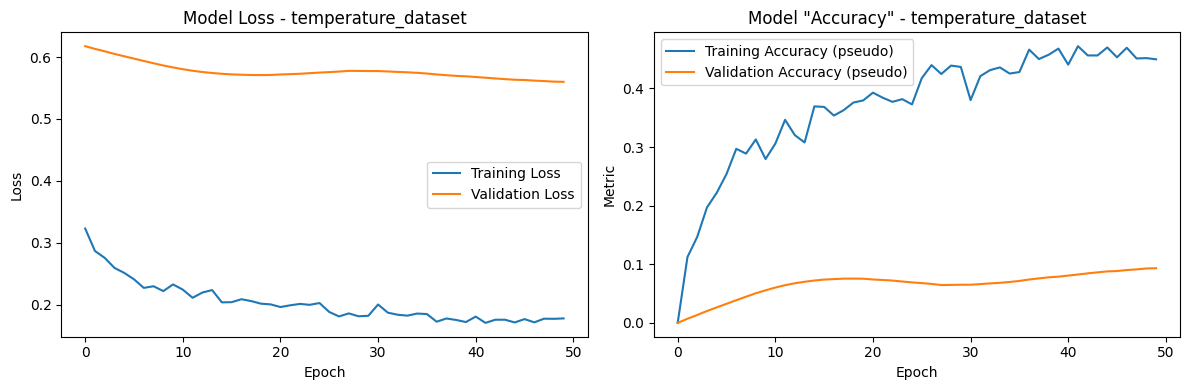


Training Summary for temperature_dataset:
Final training loss: 0.1777
Final validation loss: 0.5601
Model saved to: lstm_models/lstm_temperature_dataset_20241210_172919.h5
History saved to: training_history/history_temperature_dataset_20241210_172919.json
LSTM Anomalies Recorded:
lstm_anomaly
0    167
1      7
Name: count, dtype: int64


In [71]:
print("Training Temperature Model...")
temp_detector, temp_history, temp_df = train_and_save_model(
    temp_df, 'AnomalyBoth', 'temperature_dataset'
)



Training model for beijing_dataset
Value range for PM2.5: min=2.0, max=999.0
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.9625243861576412 11.373181033133847
Epoch 1/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 124s 20ms/step - loss: 0.3152 - val_loss: 0.2191 - learning_rate: 1.0000e-04
Epoch 2/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 117s 20ms/step - loss: 0.2547 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 3/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - loss: 0.2384 - val_loss: 0.2004 - learning_rate: 1.0000e-04
Epoch 4/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - loss: 0.2299 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 5/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - loss: 0.2235 - val_loss: 0.1952 - learning_rate: 1.0000e-04
Epoch 6/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - loss: 0.2188 - val_loss: 0.1883 - learning_rate: 1.0000e-04
Epoch 7/50
5794/5794 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - loss: 0.2139 - val_loss: 0.1909 - learning_rate

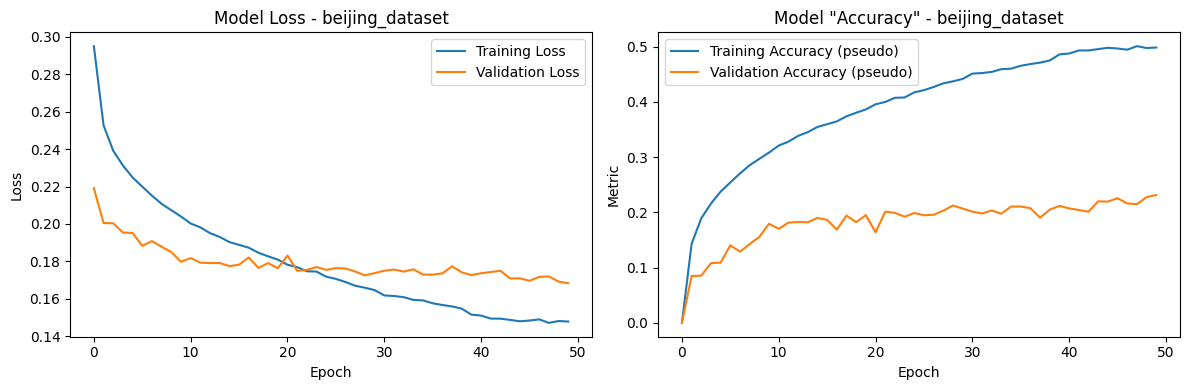


Training Summary for beijing_dataset:
Final training loss: 0.1479
Final validation loss: 0.1684
Model saved to: lstm_models/lstm_beijing_dataset_20241210_191012.h5
History saved to: training_history/history_beijing_dataset_20241210_191012.json
LSTM Anomalies Recorded:
lstm_anomaly
0    391430
1     20599
Name: count, dtype: int64
LSTM anomalies assigned successfully to Beijing dataset:
   PM2.5  lstm_anomaly
0    4.0             0
1    7.0             0
2    5.0             0
3    6.0             0
4    5.0             0
5    6.0             0
6    5.0             0
7    5.0             0
8    8.0             0
9    8.0             0


In [73]:
beijing_df['PM2.5'] = pd.to_numeric(beijing_df['PM2.5'], errors='coerce')
beijing_df = beijing_df.dropna(subset=['PM2.5']).reset_index(drop=True)

beijing_detector, beijing_history, beijing_df = train_and_save_model(
    beijing_df, 'PM2.5', 'beijing_dataset'
)


if 'lstm_anomaly' in beijing_df.columns:
    print("LSTM anomalies assigned successfully to Beijing dataset:")
    print(beijing_df[['PM2.5', 'lstm_anomaly']].head(10))
else:
    print("No 'lstm_anomaly' column found. Check the train_and_save_model function.")



Training NAB Models...

Training model for nab_realTraffic
Value range for value: min=0.0, max=5578.0
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.47707255758352646 20.543812534153844
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.1545 - val_loss: 0.0354 - learning_rate: 1.0000e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1334 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1260 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1212 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1155 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1121 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1086 - val_loss: 0.0062 - learning_rate:

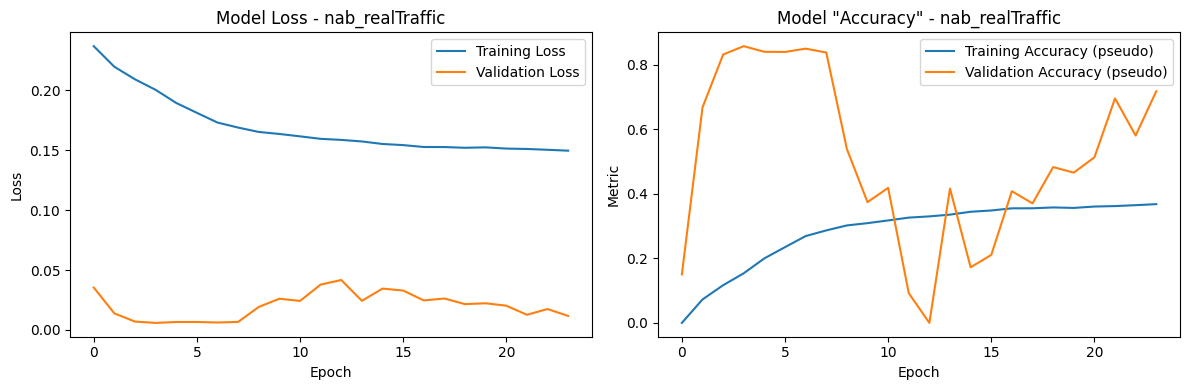


Training Summary for nab_realTraffic:
Final training loss: 0.1496
Final validation loss: 0.0117
Model saved to: lstm_models/lstm_nab_realTraffic_20241210_203908.h5
History saved to: training_history/history_nab_realTraffic_20241210_203908.json
LSTM Anomalies Recorded:
lstm_anomaly
0    14883
1      781
Name: count, dtype: int64

Training model for nab_realAdExchange
Value range for value: min=0.000385004945833, max=16.4381996801
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.7559466459453407 37.4332253997755
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2158 - val_loss: 0.1846 - learning_rate: 1.0000e-04
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2060 - val_loss: 0.1725 - learning_rate: 1.0000e-04
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2011 - val_loss: 0.1159 - learning_rate: 1.0000e-04
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1965 - val_loss: 0.1474 - learning_rate: 1.0000e-04
Epoch

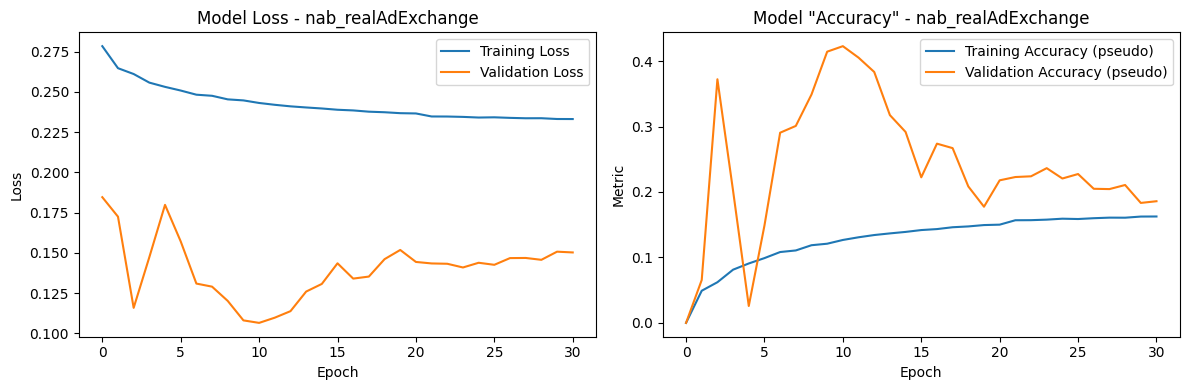


Training Summary for nab_realAdExchange:
Final training loss: 0.2331
Final validation loss: 0.1503
Model saved to: lstm_models/lstm_nab_realAdExchange_20241210_204047.h5
History saved to: training_history/history_nab_realAdExchange_20241210_204047.json
LSTM Anomalies Recorded:
lstm_anomaly
0    9132
1     478
Name: count, dtype: int64

Training model for nab_realTweets
Value range for value: min=0.0, max=13479.0
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.1911350798918668 126.55419663870659
Epoch 1/50
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 0.0982 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 2/50
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - loss: 0.0841 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 3/50
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - loss: 0.0827 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 4/50
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - loss: 0.0816 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 5/5

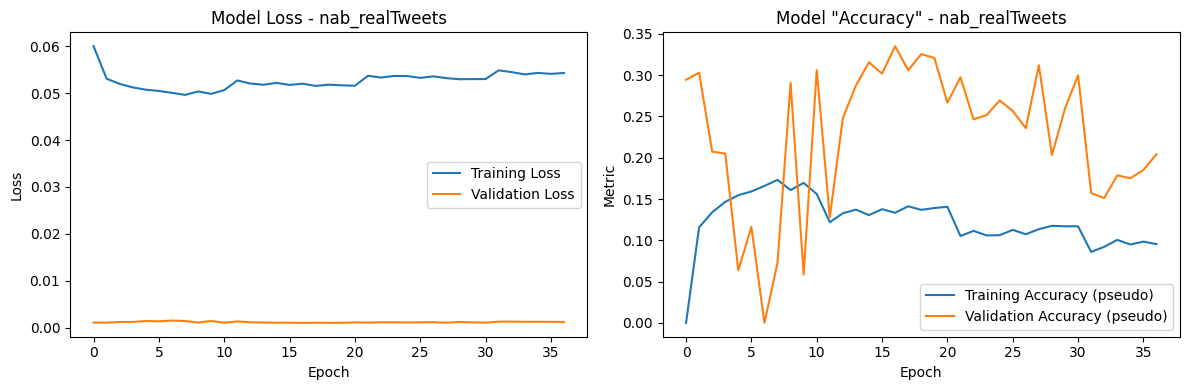


Training Summary for nab_realTweets:
Final training loss: 0.0543
Final validation loss: 0.0012
Model saved to: lstm_models/lstm_nab_realTweets_20241210_210955.h5
History saved to: training_history/history_nab_realTweets_20241210_210955.json
LSTM Anomalies Recorded:
lstm_anomaly
0    150702
1      7929
Name: count, dtype: int64

Training model for nab_realKnownCause
Value range for value: min=0.0, max=39197.0
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.38294144607163927 6.16067849969558
Epoch 1/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 0.1844 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 2/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.1239 - val_loss: 0.0519 - learning_rate: 1.0000e-04
Epoch 3/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0956 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 4/50
978/978 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0831 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 5/50
978/978 ━━━

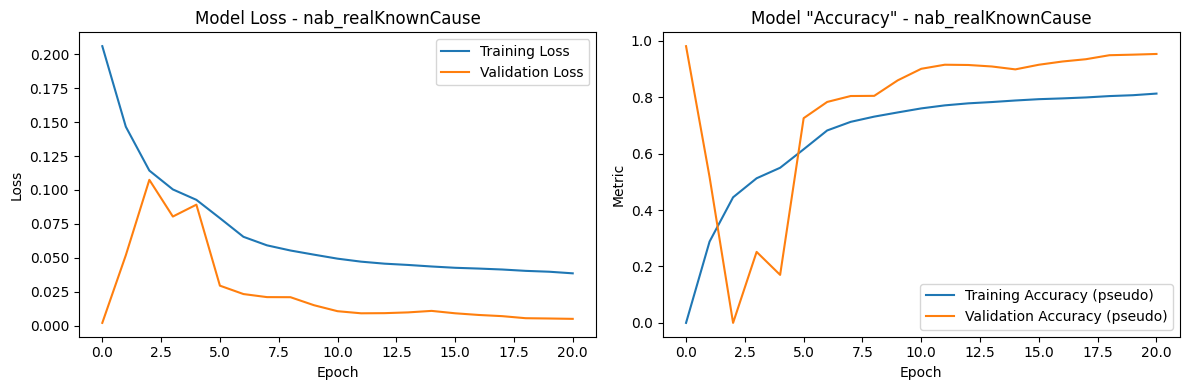


Training Summary for nab_realKnownCause:
Final training loss: 0.0386
Final validation loss: 0.0050
Model saved to: lstm_models/lstm_nab_realKnownCause_20241210_211723.h5
History saved to: training_history/history_nab_realKnownCause_20241210_211723.json
LSTM Anomalies Recorded:
lstm_anomaly
0    66085
1     3476
Name: count, dtype: int64

Training model for nab_realAWSCloudwatch
Value range for value: min=0.0, max=863964000.0
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -0.07149737626759299 38.10313689941639
Epoch 1/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0335 - val_loss: 0.3210 - learning_rate: 1.0000e-04
Epoch 2/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0287 - val_loss: 0.3234 - learning_rate: 1.0000e-04
Epoch 3/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0281 - val_loss: 0.3204 - learning_rate: 1.0000e-04
Epoch 4/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0278 - val_loss: 0.3192 - learning_rate: 1.0000e-04
Epoc

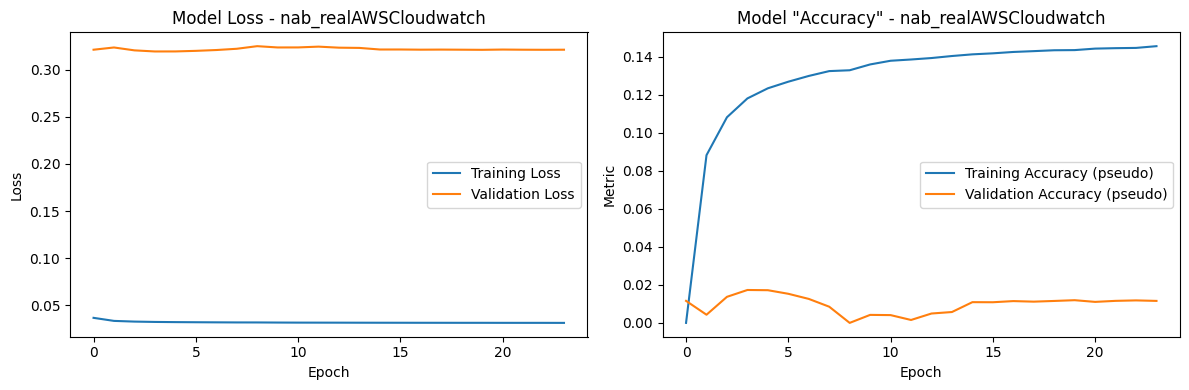


Training Summary for nab_realAWSCloudwatch:
Final training loss: 0.0314
Final validation loss: 0.3211
Model saved to: lstm_models/lstm_nab_realAWSCloudwatch_20241210_212536.h5
History saved to: training_history/history_nab_realAWSCloudwatch_20241210_212536.json
LSTM Anomalies Recorded:
lstm_anomaly
0    64355
1     3385
Name: count, dtype: int64

Training model for nab_artificialWithAnomaly
Value range for value: min=-21.998788838600007, max=164.947480513
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -1.3779735165527904 4.175389734596987
Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.3534 - val_loss: 0.0729 - learning_rate: 1.0000e-04
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.2677 - val_loss: 0.0179 - learning_rate: 1.0000e-04
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1648 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1336 - val_loss: 0.1022 - lea

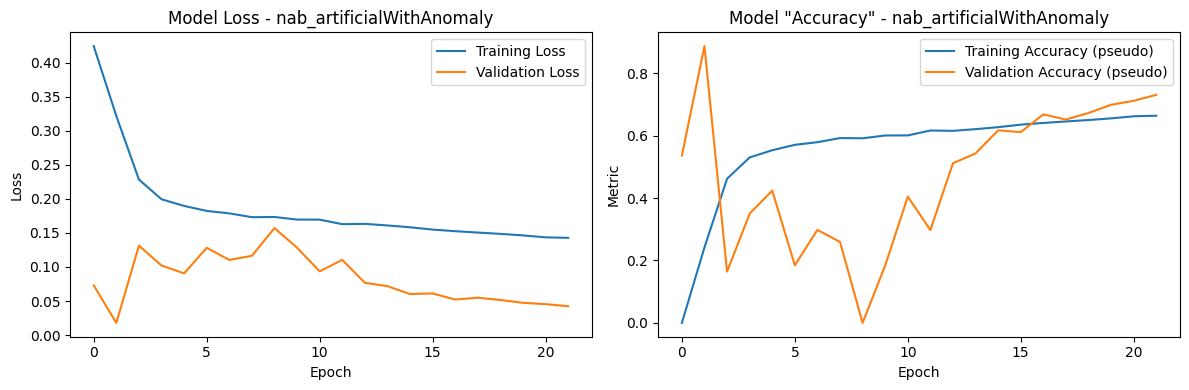


Training Summary for nab_artificialWithAnomaly:
Final training loss: 0.1428
Final validation loss: 0.0423
Model saved to: lstm_models/lstm_nab_artificialWithAnomaly_20241210_212827.h5
History saved to: training_history/history_nab_artificialWithAnomaly_20241210_212827.json
LSTM Anomalies Recorded:
lstm_anomaly
0    22984
1     1208
Name: count, dtype: int64

Training model for nab_artificialNoAnomaly
Value range for value: min=8.0005810963, max=87.97612832639999
NaNs after scaling: 0
Infs after scaling: 0
Scaled data range: -1.1665246724104337 2.0300928459641243
Epoch 1/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.4519 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.4054 - val_loss: 0.3308 - learning_rate: 1.0000e-04
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.3568 - val_loss: 0.2737 - learning_rate: 1.0000e-04
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2773 - val_loss: 0.28

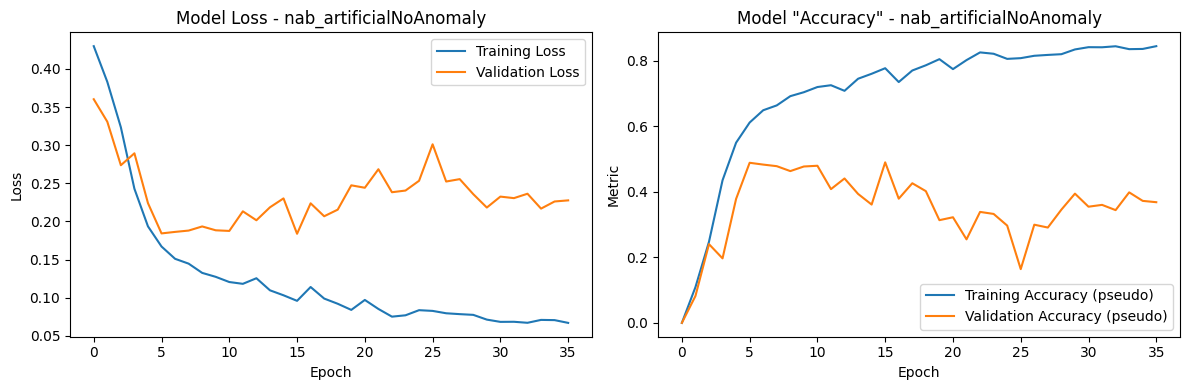


Training Summary for nab_artificialNoAnomaly:
Final training loss: 0.0669
Final validation loss: 0.2276
Model saved to: lstm_models/lstm_nab_artificialNoAnomaly_20241210_213214.h5
History saved to: training_history/history_nab_artificialNoAnomaly_20241210_213214.json
LSTM Anomalies Recorded:
lstm_anomaly
0    19154
1     1006
Name: count, dtype: int64


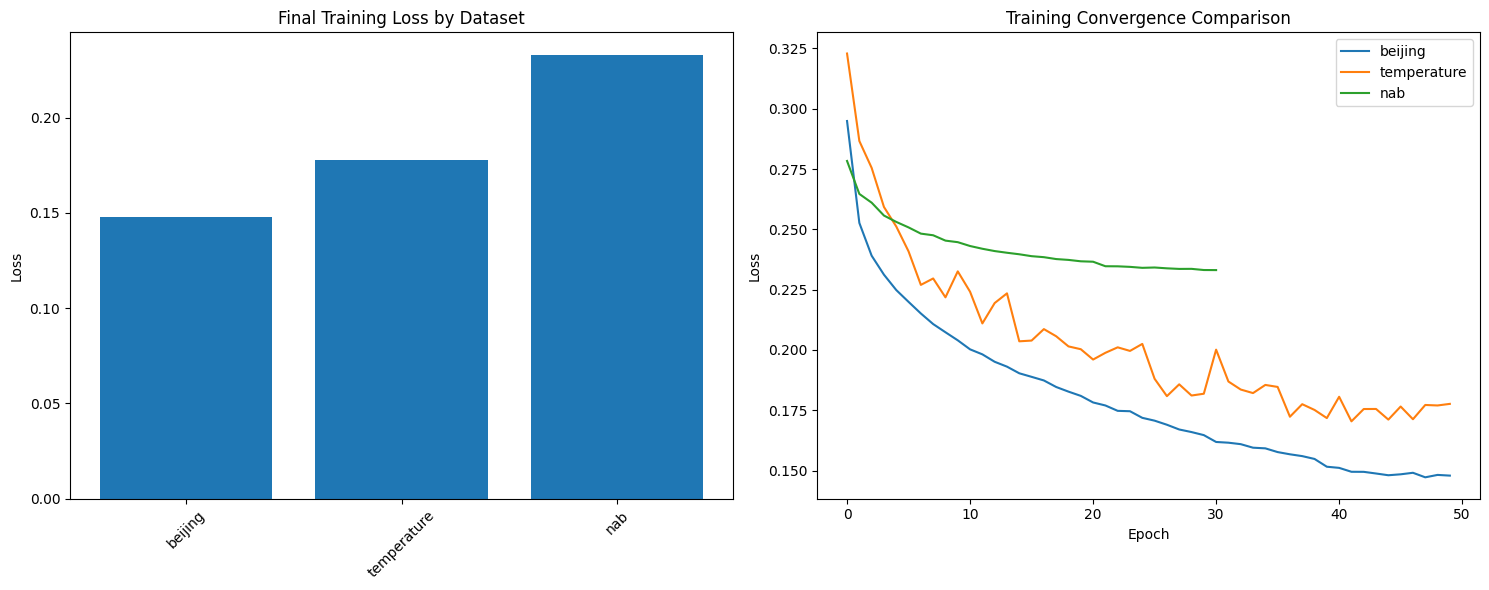

In [107]:
print("\nTraining NAB Models...")
for category in nab_df['category'].unique():
    category_data = nab_df[nab_df['category'] == category].copy()
    nab_detector, nab_history, category_data = train_and_save_model(
        category_data, 'value', f'nab_{category}'
    )
    nab_df.loc[nab_df['category'] == category, ['lstm_anomaly', 'mae_loss']] = category_data[['lstm_anomaly', 'mae_loss']].values

def compare_training_histories():
    history_dir = 'training_history'
    histories = {}

    for filename in os.listdir(history_dir):
        if filename.endswith('.json'):
            with open(os.path.join(history_dir, filename), 'r') as f:
                dataset_name = filename.split('_')[1]
                histories[dataset_name] = json.load(f)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    datasets = list(histories.keys())
    final_losses = [hist['loss'][-1] for hist in histories.values()]
    plt.bar(datasets, final_losses)
    plt.xticks(rotation=45)
    plt.title('Final Training Loss by Dataset')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    for dataset, hist in histories.items():
        plt.plot(hist['loss'], label=dataset)
    plt.title('Training Convergence Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_training_histories()

## Defining Anomalies

we recorded LSTM-based anomaly predictions in a column called lstm_anomaly. The next step is to ensure that we have consistent definition of “true anomalies” (y_true) and “predicted anomalies” (y_pred) for each dataset so that we can use them in the metrics.

Beijing Air Quality

In [109]:
aqi = beijing_df['PM2.5']
threshold_aqi = aqi.quantile(0.95)
beijing_df['anomaly'] = (aqi > threshold_aqi).astype(int)
beijing_df['anomaly'] = beijing_df['anomaly'].shift(-1).fillna(0).astype(int)


In [110]:
if 'lstm_anomaly' in beijing_df.columns:
    print("Beijing Air Quality LSTM Anomalies:")
    print(beijing_df['lstm_anomaly'].value_counts())
else:
    print("No lstm_anomaly found for dataset")


Beijing Air Quality LSTM Anomalies:
lstm_anomaly
0    391430
1     20599
Name: count, dtype: int64


In [111]:
print(beijing_df.tail(10))

           No  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO  ...  \
412019  35055  2017      2   28    14    3.0  17.0  2.0   6.0  200.0  ...   
412020  35056  2017      2   28    15    5.0  19.0  3.0   6.0  200.0  ...   
412021  35057  2017      2   28    16    9.0  22.0  4.0  10.0  300.0  ...   
412022  35058  2017      2   28    17   11.0  28.0  4.0  11.0  300.0  ...   
412023  35059  2017      2   28    18    6.0  37.0  3.0  20.0  400.0  ...   
412024  35060  2017      2   28    19   11.0  27.0  4.0  20.0  300.0  ...   
412025  35061  2017      2   28    20   15.0  43.0  6.0  55.0  500.0  ...   
412026  35062  2017      2   28    21   13.0  35.0  7.0  48.0  500.0  ...   
412027  35063  2017      2   28    22   12.0  31.0  5.0  47.0  500.0  ...   
412028  35064  2017      2   28    23    7.0  25.0  6.0  86.0  700.0  ...   

        TEMP    PRES  DEWP  RAIN   wd WSPM  station lstm_anomaly  mae_loss  \
412019  16.2  1011.7 -14.4   0.0   NW  2.6   Wanliu            0  0.172105

Global Temperature Dataset

In [112]:
temp_anomaly = temp_df['AnomalyBoth']
mean_anomaly = temp_anomaly.mean()
std_anomaly = temp_anomaly.std()
upper_threshold = mean_anomaly + 2 * std_anomaly
temp_df['anomaly'] = (temp_anomaly > upper_threshold).astype(int)
temp_df['anomaly'] = temp_df['anomaly'].shift(-1).fillna(0).astype(int)

print("\nGlobal Temperature Anomalies Defined:")
print(temp_df['anomaly'].value_counts())
print(temp_df[['AnomalyBoth', 'anomaly']].head())

# After LSTM training on temperature data
if 'lstm_anomaly' in temp_df.columns:
    print("Global Temperature LSTM Anomalies:")
    print(temp_df['lstm_anomaly'].value_counts())
    print(temp_df[['AnomalyBoth', 'anomaly', 'lstm_anomaly']].head())
else:
    print("No lstm_anomaly found for dataset")



Global Temperature Anomalies Defined:
anomaly
0    164
1     10
Name: count, dtype: int64
   AnomalyBoth  anomaly
0        -0.17        0
1        -0.09        0
2        -0.10        0
3        -0.12        0
4        -0.11        0
Global Temperature LSTM Anomalies:
lstm_anomaly
0    167
1      7
Name: count, dtype: int64
   AnomalyBoth  anomaly  lstm_anomaly
0        -0.17        0             0
1        -0.09        0             0
2        -0.10        0             0
3        -0.12        0             0
4        -0.11        0             0


In [113]:
print(temp_df.columns)
print(temp_df[['AnomalyBoth', 'anomaly', 'lstm_anomaly', 'mae_loss']].head())

Index(['Year', 'AnomalyBoth', 'AnomalyLand', 'AnomalyOcean', 'anomaly',
       'lstm_anomaly', 'mae_loss'],
      dtype='object')
   AnomalyBoth  anomaly  lstm_anomaly  mae_loss
0        -0.17        0             0       0.0
1        -0.09        0             0       0.0
2        -0.10        0             0       0.0
3        -0.12        0             0       0.0
4        -0.11        0             0       0.0


In [114]:
print(temp_df.tail(10))

     Year  AnomalyBoth  AnomalyLand  AnomalyOcean  anomaly  lstm_anomaly  \
164  2014         0.77         1.12          0.61        1             0   
165  2015         0.92         1.35          0.72        1             0   
166  2016         1.03         1.65          0.76        1             0   
167  2017         0.95         1.51          0.70        1             1   
168  2018         0.86         1.32          0.66        1             1   
169  2019         0.98         1.51          0.74        1             1   
170  2020         1.01         1.65          0.73        1             1   
171  2021         0.86         1.37          0.63        1             1   
172  2022         0.91         1.43          0.67        1             1   
173  2023         1.18         1.79          0.91        0             1   

     mae_loss  
164  0.829740  
165  0.857304  
166  0.897332  
167  0.944787  
168  0.990590  
169  1.027807  
170  1.074749  
171  1.125796  
172  1.165068  
173

NAB Datasets

In [115]:
for category in nab_df['category'].unique():
    category_data = nab_df[nab_df['category'] == category]
    dataset_values = category_data['value']
    threshold_percentile = dataset_values.quantile(0.95)
    mean_value = dataset_values.mean()
    std_value = dataset_values.std()
    threshold_std = mean_value + 2 * std_value

    nab_df.loc[nab_df['category'] == category, 'anomaly'] = (
        ((dataset_values > threshold_percentile) |
         (dataset_values > threshold_std))
    ).astype(int)

    nab_df.loc[nab_df['category'] == category, 'anomaly'] = (
        nab_df.loc[nab_df['category'] == category, 'anomaly']
        .shift(-1)
        .fillna(0)
        .astype(int)
    )


In [116]:
if 'lstm_anomaly' in nab_df.columns:
    print("NAB LSTM Anomalies:")
    print(nab_df['lstm_anomaly'].value_counts())
    print(nab_df[['value', 'anomaly', 'lstm_anomaly']].head())
else:
    print("No lstm_anomaly found for NAB dataset")

NAB LSTM Anomalies:
lstm_anomaly
0.0    347295
1.0     18263
Name: count, dtype: int64
                     value  anomaly  lstm_anomaly
timestamp                                        
2015-09-01 11:25:00   58.0      0.0           0.0
2015-09-01 11:30:00   63.0      0.0           0.0
2015-09-01 11:35:00   63.0      0.0           0.0
2015-09-01 11:40:00   64.0      0.0           0.0
2015-09-01 11:55:00   58.0      0.0           0.0


## Applying Anomaly Detection Algorithms

## Implementing Evaluation Metrics

### Range-Based Precision and Recall with Front-End Bias

In [117]:
def range_based_precision_recall(y_true, y_pred, alpha=0.5, bias='front'):
    """
    Calculates range-based precision and recall with positional bias and quadratic decay.
    """
    def get_ranges(series):
        ranges = []
        start = None
        for i, val in enumerate(series):
            if val == 1 and start is None:
                start = i
            elif val == 0 and start is not None:
                ranges.append((start, i - 1))
                start = None
        if start is not None:
            ranges.append((start, len(series) - 1))
        return ranges

    true_ranges = get_ranges(y_true)
    pred_ranges = get_ranges(y_pred)

    def delta(position, length):
        if bias == 'front':
            return 1 - (position / max(length, 1))**2  # Quadratic decay for stronger early emphasis
        elif bias == 'back':
            return (position / max(length, 1))**2
        elif bias == 'middle':
            return 1 - abs((position - (length / 2)) / (length / 2))**2
        else:
            return 1

    def gamma(num_overlaps):
        return 1 / (num_overlaps**2) if num_overlaps > 0 else 0  # Squared penalty for fragmentation

    # Calculate Recall_T
    recall_scores = []
    for tr_start, tr_end in true_ranges:
        overlaps = []
        for pr_start, pr_end in pred_ranges:
            overlap_start = max(tr_start, pr_start)
            overlap_end = min(tr_end, pr_end)
            if overlap_start <= overlap_end:
                position = overlap_start - tr_start
                length = tr_end - tr_start + 1
                overlaps.append(delta(position, length))
        if overlaps:
            cardinality = gamma(len(overlaps))
            overlap_reward = cardinality * sum(overlaps)
            recall = alpha * 1 + (1 - alpha) * overlap_reward
            recall_scores.append(recall)
        else:
            recall_scores.append(0)
    Recall_T = np.mean(recall_scores) if recall_scores else 0

    # Calculate Precision_T
    precision_scores = []
    for pr_start, pr_end in pred_ranges:
        overlaps = []
        for tr_start, tr_end in true_ranges:
            overlap_start = max(tr_start, pr_start)
            overlap_end = min(tr_end, pr_end)
            if overlap_start <= overlap_end:
                position = overlap_start - pr_start
                length = pr_end - pr_start + 1
                overlaps.append(delta(position, length))
        if overlaps:
            cardinality = gamma(len(overlaps))
            overlap_reward = cardinality * sum(overlaps)
            precision = alpha * 1 + (1 - alpha) * overlap_reward
            precision_scores.append(precision)
        else:
            precision_scores.append(0)
    Precision_T = np.mean(precision_scores) if precision_scores else 0

    return Precision_T, Recall_T

### Window-Based F1 Score

In [118]:
def window_based_f1_score(y_true, y_pred, window_size=5):
    """
    # Smaller window size for more precise temporal localization
    # Rolling max to capture any detection within window
    """
    y_true_window = pd.Series(y_true).rolling(window=window_size, min_periods=1).max()
    y_pred_window = pd.Series(y_pred).rolling(window=window_size, min_periods=1).max()
    return f1_score(y_true_window, y_pred_window)

### NAB Score

In [119]:
def nab_score(y_true, y_pred, anomaly_window=10):
    """
    # Adjusted weights based on NAB paper recommendations
    # Stronger penalty for false positives to reduce noise
    """
    tp_weight = 1.0
    fp_weight = -0.5
    fn_weight = -1.0

    score = 0.0
    n = len(y_true)

    for i in range(n):
        if y_true[i] == 1:
            window_start = max(0, i - anomaly_window//2)
            window_end = min(i + anomaly_window//2, n)
            if 1 in y_pred[window_start:window_end]:
                score += tp_weight * (1 - (i - window_start)/(window_end - window_start))
            else:
                score += fn_weight
        elif y_pred[i] == 1:
            score += fp_weight

    max_score = sum([tp_weight if val == 1 else 0 for val in y_true])
    min_score = sum([fn_weight if val == 1 else 0 for val in y_true])

    normalized_score = (score - min_score) / (max_score - min_score) * 100
    return normalized_score

### AUC Score

In [120]:
def calculate_auc(y_true, y_scores):
    """
    # Standard AUC implementation
    # Used as baseline metric alongside temporal-aware metrics
    """
    return roc_auc_score(y_true, y_scores)

## Evaluating the Models

In [121]:
def compare_metric_performance_lstm():
    """
    Compares metric performance across all datasets based on LSTM predictions.
    Includes AUC as an additional metric.
    """
    metrics = ['precision', 'recall', 'f1', 'nab', 'auc']
    datasets = {
        'Beijing': (beijing_df, 'PM2.5'),
        'Temperature': (temp_df, 'AnomalyBoth')
    }

    for category in nab_df['category'].unique():
        datasets[f'NAB_{category}'] = (nab_df[nab_df['category'] == category], 'value')

    results = {metric: {} for metric in metrics}

    for dataset_name, (dataset, col) in datasets.items():
        print(f"\nProcessing {dataset_name}...")
        for metric in metrics:
            if metric != 'auc':
                # For metrics other than AUC, calculate detection delays and success rates
                avg_delay, success_rate = analyze_metric_timing_lstm(
                    dataset, metric_type=metric, detection_threshold=0.7, max_delay=10
                )
                results[metric][dataset_name] = {'avg_delay': avg_delay, 'success_rate': success_rate}
            else:
                # For AUC, store the auc_score directly
                y_true = dataset['anomaly'].values
                y_scores = dataset['mae_loss'].values

                # Replace NaNs
                y_true = np.nan_to_num(y_true, nan=0)
                y_scores = np.nan_to_num(y_scores, nan=0)

                if len(np.unique(y_true)) < 2:
                    auc_score = np.nan
                    print(f"{dataset_name}: Only one class present in y_true. AUC is undefined.")
                else:
                    try:
                        auc_score = roc_auc_score(y_true, y_scores)
                    except Exception as e:
                        print(f"{dataset_name}: Error calculating AUC: {e}")
                        auc_score = np.nan

                results[metric][dataset_name] = {'auc_score': auc_score}

    # Visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 25))
    fig.suptitle('Metric Performance Comparison (LSTM Predictions)', fontsize=20)

    metric_names = {'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1 Score', 'nab': 'NAB Score', 'auc': 'AUC Score'}
    plot_idx = 0
    for metric in metrics:
        ax = axes[plot_idx // 2, plot_idx % 2]
        if metric in ['precision', 'recall', 'f1', 'nab']:
            data = results.get(metric, {})
            if data:
                dataset_names = list(data.keys())
                delays = [r['avg_delay'] for r in data.values()]
                rates = [r['success_rate'] * 100 for r in data.values()]  # Convert to percentage

                ax2 = ax.twinx()

                bars1 = ax.barh(dataset_names, delays, alpha=0.6, color='skyblue', label='Avg Detection Delay')
                ax.set_xlabel('Average Detection Delay (timesteps)')
                ax.set_ylabel('Datasets')
                ax.set_title(f'{metric_names[metric]} Performance', fontsize=14)

                bars2 = ax2.barh(dataset_names, rates, alpha=0.6, color='salmon', label='Success Rate (%)')
                ax2.set_xlabel('Success Rate (%)')

                # Legends
                ax.legend(loc='upper left')
                ax2.legend(loc='upper right')
        elif metric == 'auc':
            data = results.get(metric, {})
            if data:
                dataset_names = [name for name, val in data.items() if not np.isnan(val['auc_score'])]
                auc_scores = [val['auc_score'] for val in data.values() if not np.isnan(val['auc_score'])]

                bars = ax.barh(dataset_names, auc_scores, color='lightgreen')
                ax.set_xlabel('AUC Score')
                ax.set_title(f'{metric_names[metric]} Performance', fontsize=14)

                # Annotate bars with AUC values
                for bar in bars:
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                            f'{width:.2f}', va='center')

        plot_idx += 1

    # Remove empty subplots if any
    total_plots = len(metrics)
    if total_plots < 6:
        for i in range(total_plots, 6):
            fig.delaxes(axes[i // 2, i % 2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics by Metric:")
    for metric in metrics:
        data = results.get(metric, {})
        if metric in ['precision', 'recall', 'f1', 'nab']:
            if data:
                delays = [r['avg_delay'] for r in data.values()]
                rates = [r['success_rate'] for r in data.values()]
                best_dataset = min(data.items(), key=lambda x: x[1]['avg_delay'])[0]
                print(f"\n{metric_names[metric]}:")
                print(f"Average Detection Delay: {np.mean(delays):.2f} timesteps")
                print(f"Average Success Rate: {np.mean(rates)*100:.1f}%")
                print(f"Best Dataset: {best_dataset}")
        elif metric == 'auc':
            if data:
                auc_scores = [r['auc_score'] for r in data.values() if not np.isnan(r['auc_score'])]
                if auc_scores:
                    avg_auc = np.mean(auc_scores)
                    best_dataset = max(data.items(), key=lambda x: x[1]['auc_score'])[0]
                    print(f"\n{metric_names[metric]}:")
                    print(f"Average AUC Score: {avg_auc:.3f}")
                    print(f"Best Dataset: {best_dataset}")
                else:
                    print(f"\n{metric_names[metric]}:")
                    print("No valid AUC scores to display.")


# Visualization

In [122]:
def get_anomaly_ranges(series):

    ranges = []
    start = None
    for i, val in enumerate(series):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            ranges.append((start, i - 1))
            start = None
    if start is not None:
        ranges.append((start, len(series) - 1))
    return ranges

In [123]:
def analyze_metric_timing_lstm(data, metric_type, detection_threshold=0.7, max_delay=10):
    """
    Analyzes detection timing for a specific metric based on LSTM predictions.

    Parameters:
    - data: DataFrame containing 'anomaly' and 'lstm_anomaly' columns.
    - metric_type: Type of metric ('precision', 'recall', 'f1', 'nab').
    - detection_threshold: Minimum metric score to consider a detection successful.
    - max_delay: Maximum allowable delay for a detection.

    Returns:
    - avg_delay: Average detection delay across all anomalies.
    - success_rate: Proportion of anomalies successfully detected.
    """
    y_true = data['anomaly'].values
    y_pred = data['lstm_anomaly'].values

    y_true = np.nan_to_num(y_true, nan=0)
    y_pred = np.nan_to_num(y_pred, nan=0)

    true_ranges = get_anomaly_ranges(y_true)
    detection_delays = []
    successful_detections = 0

    for start, end in true_ranges:
        detected = False
        for i in range(start, min(end + 1, len(y_pred))):
            window = slice(start, i + 1)
            if metric_type == 'precision':
                precision, _ = range_based_precision_recall(y_true[window], y_pred[window], alpha=0.5, bias='front')
                score = precision
            elif metric_type == 'recall':
                _, recall = range_based_precision_recall(y_true[window], y_pred[window], alpha=0.5, bias='front')
                score = recall
            elif metric_type == 'f1':
                score = window_based_f1_score(y_true[window], y_pred[window], window_size=i - start + 1)
            elif metric_type == 'nab':
                score = nab_score(y_true[window], y_pred[window], anomaly_window=i - start + 1)
            else:
                score = 0

            if score > detection_threshold:
                delay = i - start
                detection_delays.append(delay)
                successful_detections += 1
                detected = True
                break

        if not detected:
            detection_delays.append(max_delay)
    avg_delay = np.mean(detection_delays) if detection_delays else max_delay
    success_rate = successful_detections / len(true_ranges) if true_ranges else 0

    return avg_delay, success_rate


In [124]:
def compare_metric_performance_lstm():
    """
    Compares metric performance across all datasets based on LSTM predictions.
    Includes AUC as an additional metric.
    """
    metrics = ['precision', 'recall', 'f1', 'nab', 'auc']
    datasets = {
        'Beijing': (beijing_df, 'PM2.5'),
        'Temperature': (temp_df, 'AnomalyBoth')
    }

    # Add NAB datasets
    for category in nab_df['category'].unique():
        datasets[f'NAB_{category}'] = (nab_df[nab_df['category'] == category], 'value')

    results = {metric: {} for metric in metrics}

    for dataset_name, (dataset, col) in datasets.items():
        print(f"\nProcessing {dataset_name}...")
        for metric in metrics:
            if metric != 'auc':
                # For metrics other than AUC, calculate detection delays and success rates
                avg_delay, success_rate = analyze_metric_timing_lstm(
                    dataset, metric_type=metric, detection_threshold=0.7, max_delay=10
                )
                results[metric][dataset_name] = {'avg_delay': avg_delay, 'success_rate': success_rate}
            else:
                # For AUC, store the auc_score directly
                y_true = dataset['anomaly'].values
                y_scores = dataset['mae_loss'].values

                # Replace NaNs
                y_true = np.nan_to_num(y_true, nan=0)
                y_scores = np.nan_to_num(y_scores, nan=0)

                if len(np.unique(y_true)) < 2:
                    auc_score = np.nan
                    print(f"{dataset_name}: Only one class present in y_true. AUC is undefined.")
                else:
                    try:
                        auc_score = roc_auc_score(y_true, y_scores)
                    except Exception as e:
                        print(f"{dataset_name}: Error calculating AUC: {e}")
                        auc_score = np.nan

                results[metric][dataset_name] = {'auc_score': auc_score}

    # Visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 25))
    fig.suptitle('Metric Performance Comparison (LSTM Predictions)', fontsize=20)

    metric_names = {'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1 Score', 'nab': 'NAB Score', 'auc': 'AUC Score'}
    plot_idx = 0
    for metric in metrics:
        ax = axes[plot_idx // 2, plot_idx % 2]
        if metric in ['precision', 'recall', 'f1', 'nab']:
            data = results.get(metric, {})
            if data:
                dataset_names = list(data.keys())
                delays = [r['avg_delay'] for r in data.values()]
                rates = [r['success_rate'] * 100 for r in data.values()]  # Convert to percentage

                ax2 = ax.twinx()

                # Plot Detection Delays
                bars1 = ax.barh(dataset_names, delays, alpha=0.6, color='skyblue', label='Avg Detection Delay')
                ax.set_xlabel('Average Detection Delay (timesteps)')
                ax.set_ylabel('Datasets')
                ax.set_title(f'{metric_names[metric]} Performance', fontsize=14)

                # Plot Success Rates
                bars2 = ax2.barh(dataset_names, rates, alpha=0.6, color='salmon', label='Success Rate (%)')
                ax2.set_xlabel('Success Rate (%)')

                # Legends
                ax.legend(loc='upper left')
                ax2.legend(loc='upper right')
        elif metric == 'auc':
            data = results.get(metric, {})
            if data:
                dataset_names = [name for name, val in data.items() if not np.isnan(val['auc_score'])]
                auc_scores = [val['auc_score'] for val in data.values() if not np.isnan(val['auc_score'])]

                bars = ax.barh(dataset_names, auc_scores, color='lightgreen')
                ax.set_xlabel('AUC Score')
                ax.set_title(f'{metric_names[metric]} Performance', fontsize=14)

                # Annotate bars with AUC values
                for bar in bars:
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                            f'{width:.2f}', va='center')

        plot_idx += 1

    # Remove empty subplots if any
    total_plots = len(metrics)
    if total_plots < 6:
        for i in range(total_plots, 6):
            fig.delaxes(axes[i // 2, i % 2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics by Metric:")
    for metric in metrics:
        data = results.get(metric, {})
        if metric in ['precision', 'recall', 'f1', 'nab']:
            if data:
                delays = [r['avg_delay'] for r in data.values()]
                rates = [r['success_rate'] for r in data.values()]
                best_dataset = min(data.items(), key=lambda x: x[1]['avg_delay'])[0]
                print(f"\n{metric_names[metric]}:")
                print(f"Average Detection Delay: {np.mean(delays):.2f} timesteps")
                print(f"Average Success Rate: {np.mean(rates)*100:.1f}%")
                print(f"Best Dataset: {best_dataset}")
        elif metric == 'auc':
            if data:
                auc_scores = [r['auc_score'] for r in data.values() if not np.isnan(r['auc_score'])]
                if auc_scores:
                    avg_auc = np.mean(auc_scores)
                    best_dataset = max(data.items(), key=lambda x: x[1]['auc_score'])[0]
                    print(f"\n{metric_names[metric]}:")
                    print(f"Average AUC Score: {avg_auc:.3f}")
                    print(f"Best Dataset: {best_dataset}")
                else:
                    print(f"\n{metric_names[metric]}:")
                    print("No valid AUC scores to display.")


In [125]:
def plot_lstm_predictions(data, value_col, dataset_name):
    """
    Plots the time series data with ground truth anomalies and LSTM-predicted anomalies.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(data.index, data[value_col], label='Data', color='blue', linewidth=1)

    # Ground Truth Anomalies
    gt_anomalies = data[data['anomaly'] == 1]
    plt.scatter(gt_anomalies.index, gt_anomalies[value_col],
                color='green', marker='x', label='Ground Truth Anomalies')

    # LSTM Predicted Anomalies
    lstm_anomalies = data[data['lstm_anomaly'] == 1]
    plt.scatter(lstm_anomalies.index, lstm_anomalies[value_col],
                color='red', marker='o', facecolors='none', label='LSTM Predicted Anomalies')

    plt.title(f"{dataset_name} - LSTM Anomaly Detection")
    plt.xlabel("Time")
    plt.ylabel(value_col)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [126]:
def visualize_all_predictions():
    plot_lstm_predictions(beijing_df, 'PM2.5', 'Beijing Air Quality')

    plot_lstm_predictions(temp_df, 'AnomalyBoth', 'Global Temperature')

    for category in nab_df['category'].unique():
        category_data = nab_df[nab_df['category'] == category]
        plot_lstm_predictions(category_data, 'value', f'NAB - {category}')


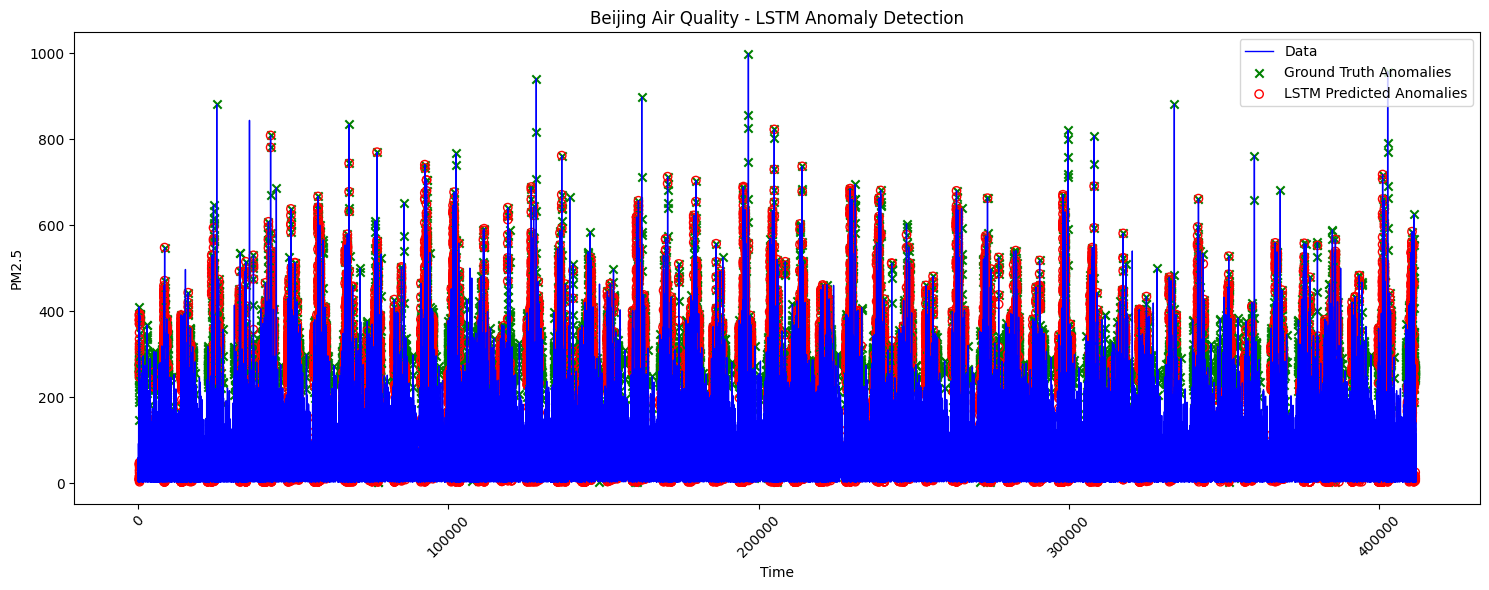

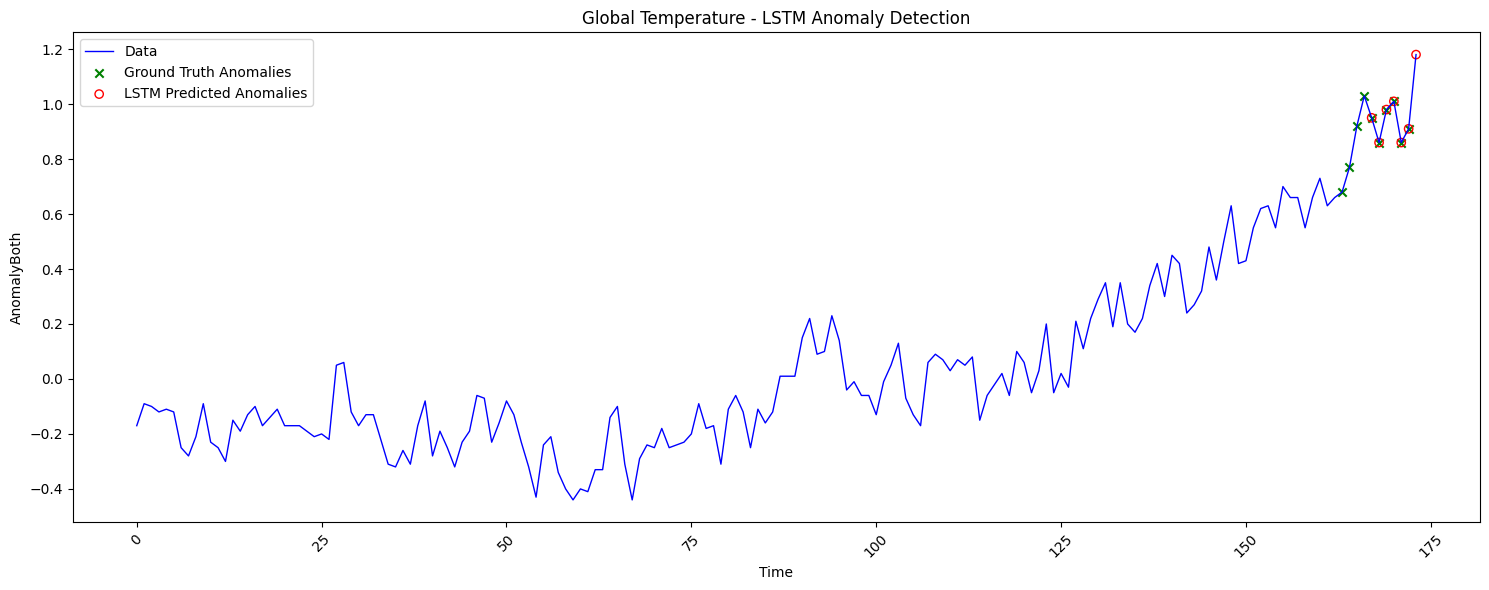

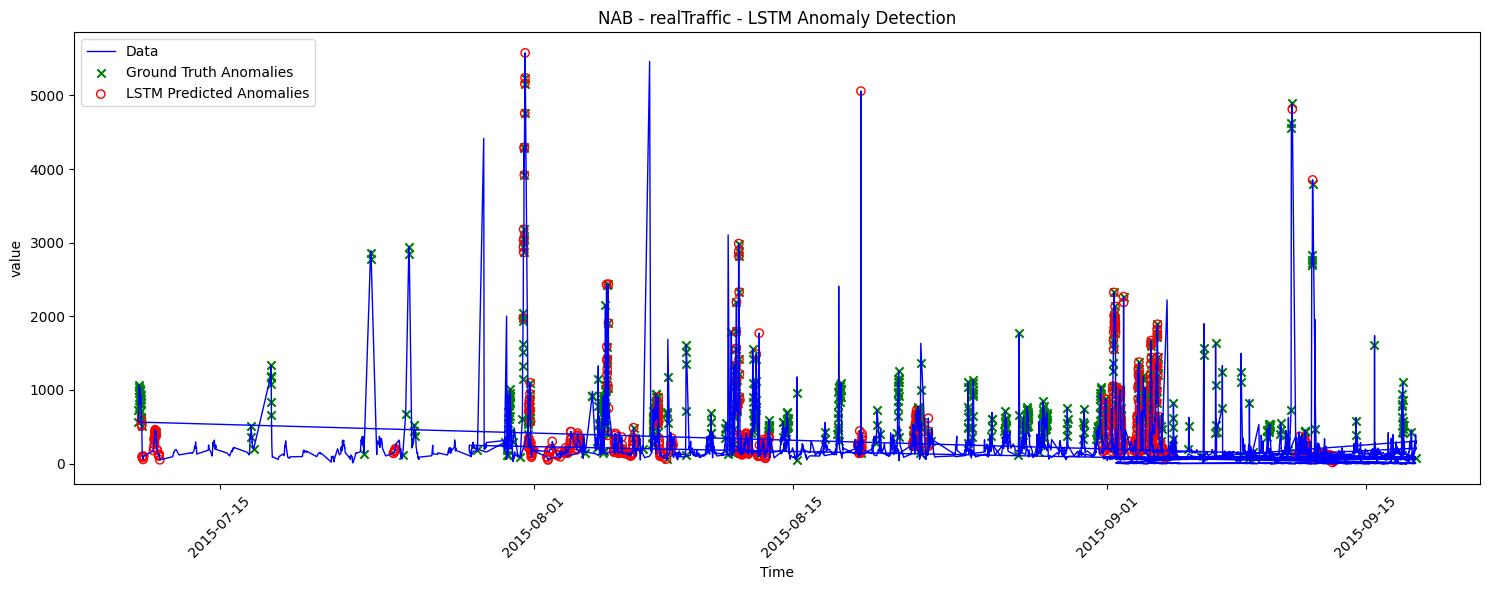

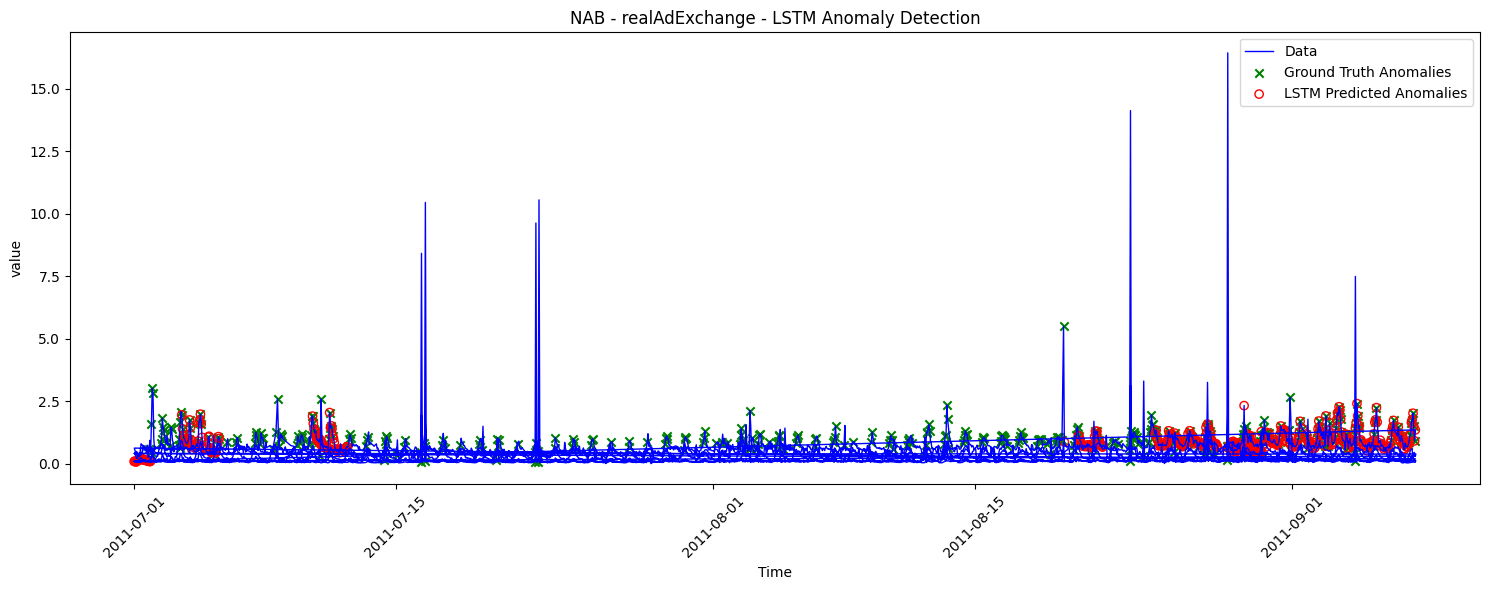

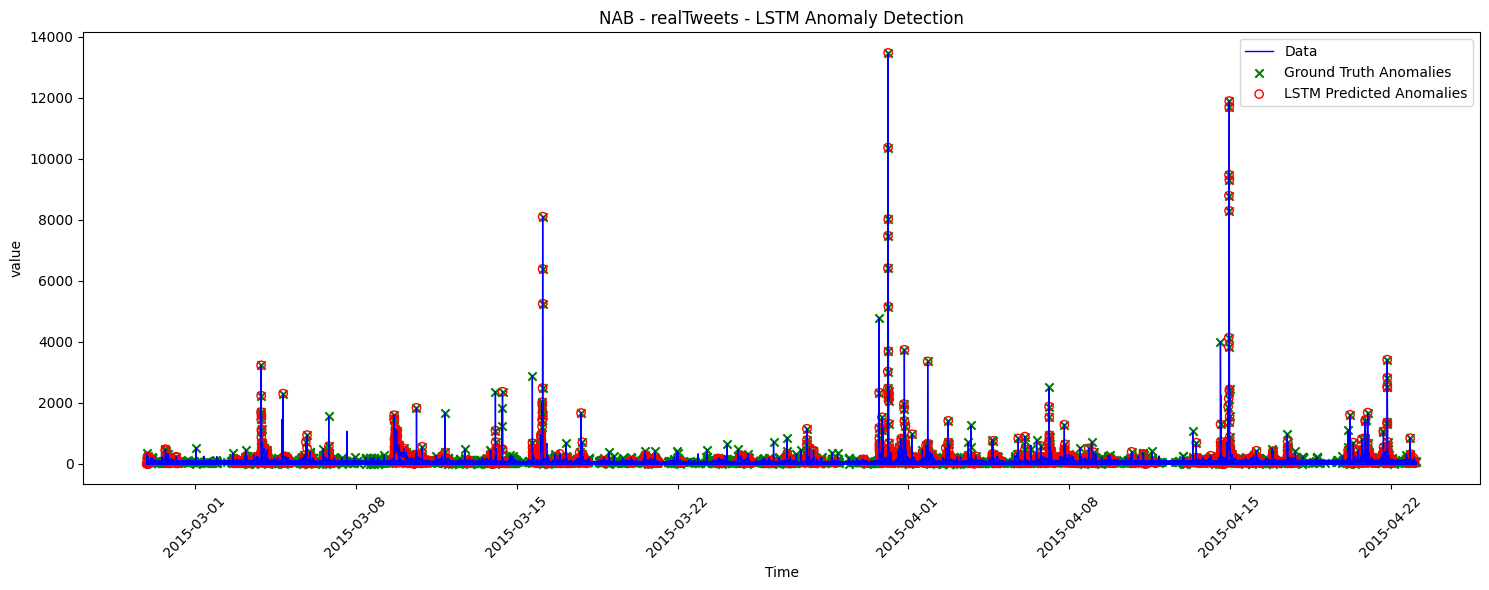

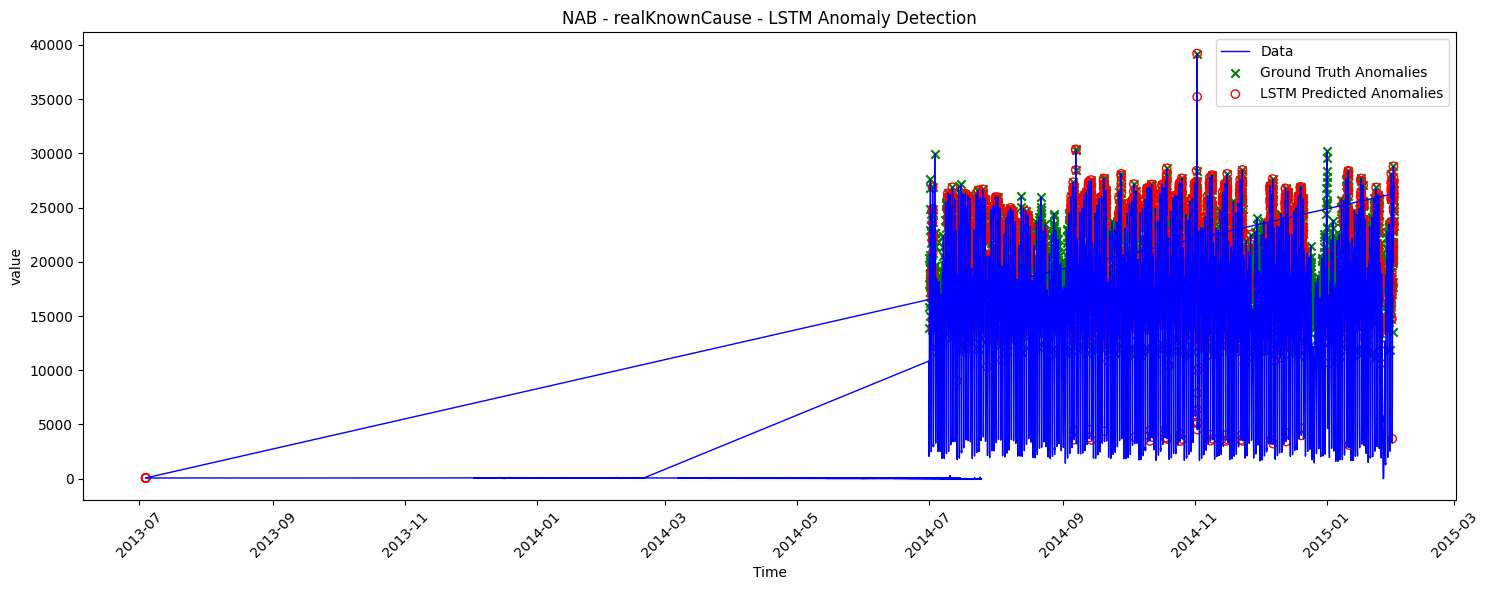

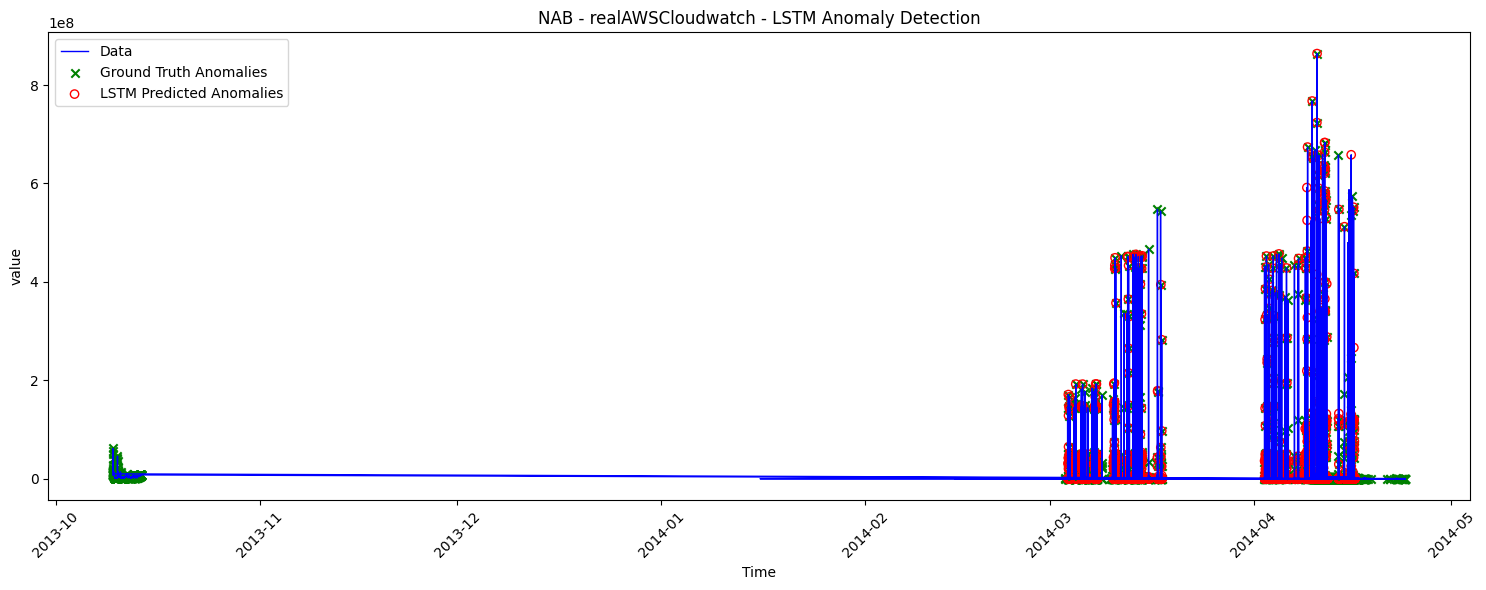

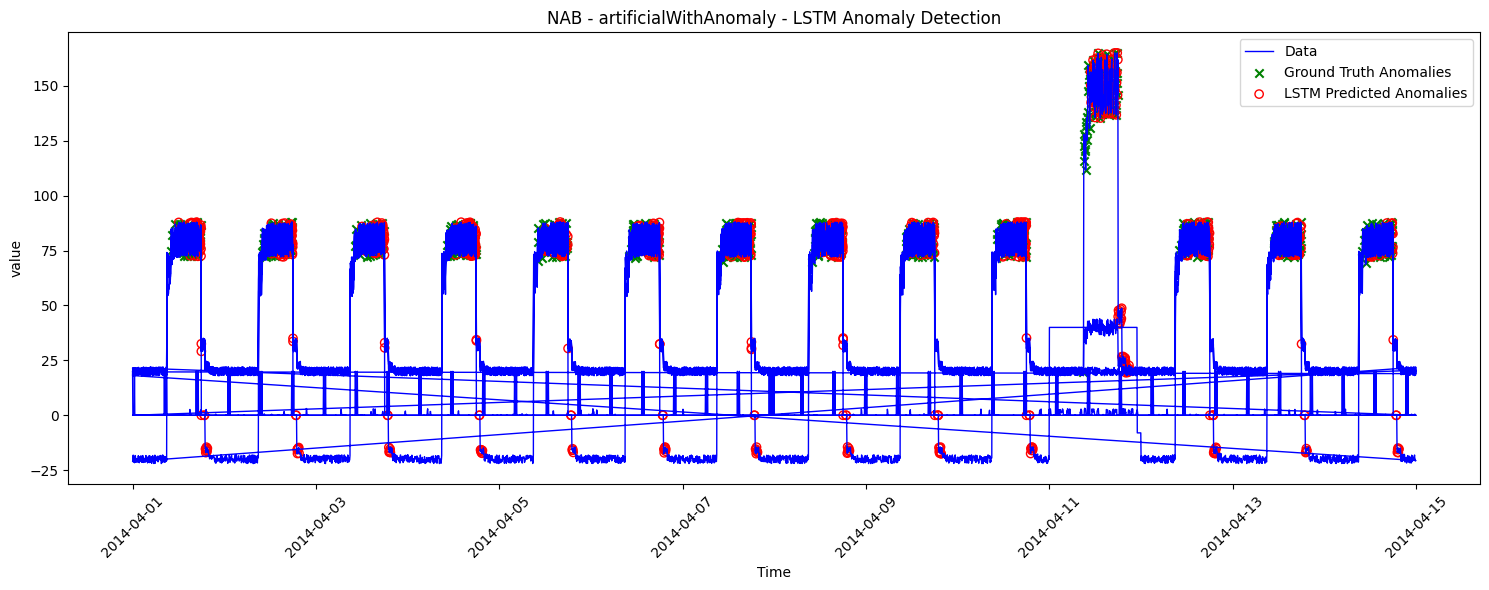

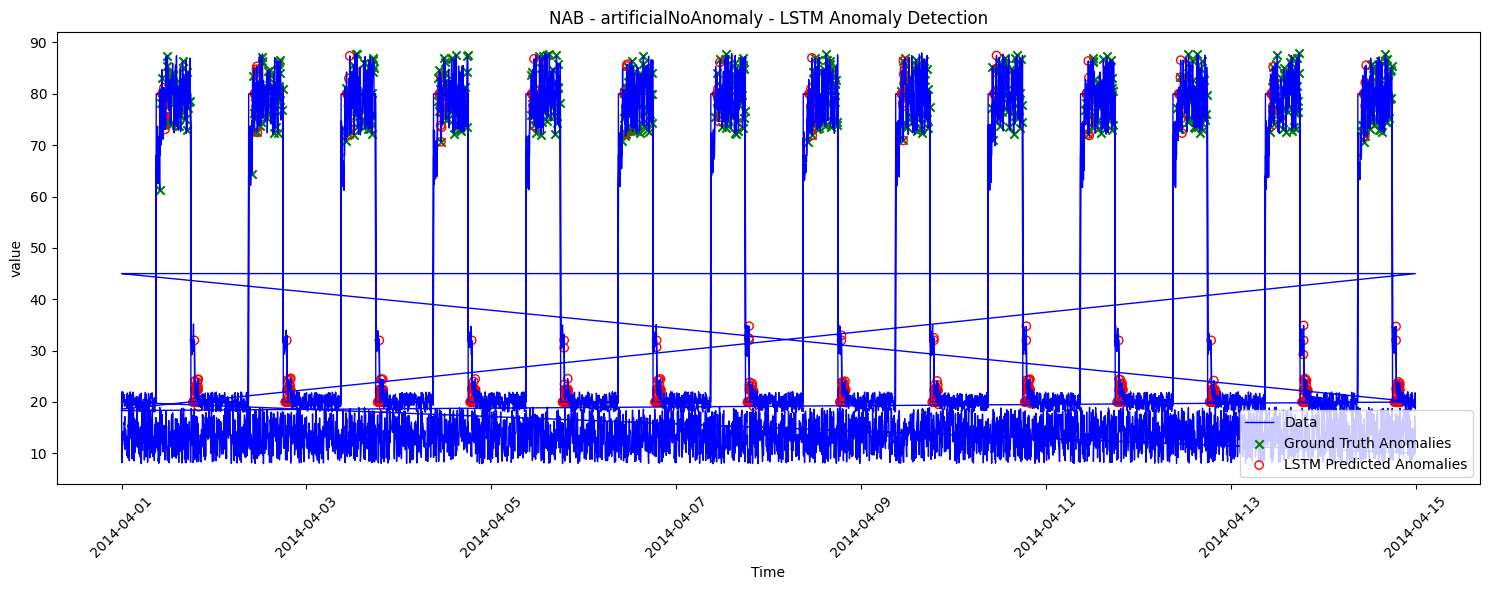

In [127]:
visualize_all_predictions()

In [128]:
!zip /content/lstm_models.zip -r /content/lstm_models

  adding: content/lstm_models/ (stored 0%)
  adding: content/lstm_models/lstm_nab_realAWSCloudwatch_20241210_212536.h5 (deflated 15%)
  adding: content/lstm_models/lstm_nab_artificialWithAnomaly_20241210_212827.h5 (deflated 15%)
  adding: content/lstm_models/lstm_temperature_dataset_20241210_172919.h5 (deflated 15%)
  adding: content/lstm_models/lstm_nab_realKnownCause_20241210_211723.h5 (deflated 15%)
  adding: content/lstm_models/.ipynb_checkpoints/ (stored 0%)
  adding: content/lstm_models/lstm_nab_realTraffic_20241210_203908.h5 (deflated 15%)
  adding: content/lstm_models/lstm_nab_realTweets_20241210_210955.h5 (deflated 15%)
  adding: content/lstm_models/lstm_beijing_dataset_20241210_191012.h5 (deflated 15%)
  adding: content/lstm_models/lstm_nab_artificialNoAnomaly_20241210_213214.h5 (deflated 15%)
  adding: content/lstm_models/lstm_nab_realAdExchange_20241210_204047.h5 (deflated 15%)


In [129]:
!zip /content/training_history.zip -r /content/training_history

  adding: content/training_history/ (stored 0%)
  adding: content/training_history/history_beijing_dataset_20241210_191012.json (deflated 69%)
  adding: content/training_history/history_temperature_dataset_20241210_172919.json (deflated 69%)
  adding: content/training_history/history_nab_artificialNoAnomaly_20241210_213214.json (deflated 67%)
  adding: content/training_history/.ipynb_checkpoints/ (stored 0%)
  adding: content/training_history/history_nab_realTweets_20241210_210955.json (deflated 68%)
  adding: content/training_history/history_nab_realTraffic_20241210_203908.json (deflated 66%)
  adding: content/training_history/history_nab_artificialWithAnomaly_20241210_212827.json (deflated 66%)
  adding: content/training_history/history_nab_realKnownCause_20241210_211723.json (deflated 65%)
  adding: content/training_history/history_nab_realAWSCloudwatch_20241210_212536.json (deflated 68%)
  adding: content/training_history/history_nab_realAdExchange_20241210_204047.json (deflated 67


Processing Beijing...

Processing Temperature...

Processing NAB_realTraffic...

Processing NAB_realAdExchange...

Processing NAB_realTweets...

Processing NAB_realKnownCause...

Processing NAB_realAWSCloudwatch...

Processing NAB_artificialWithAnomaly...

Processing NAB_artificialNoAnomaly...


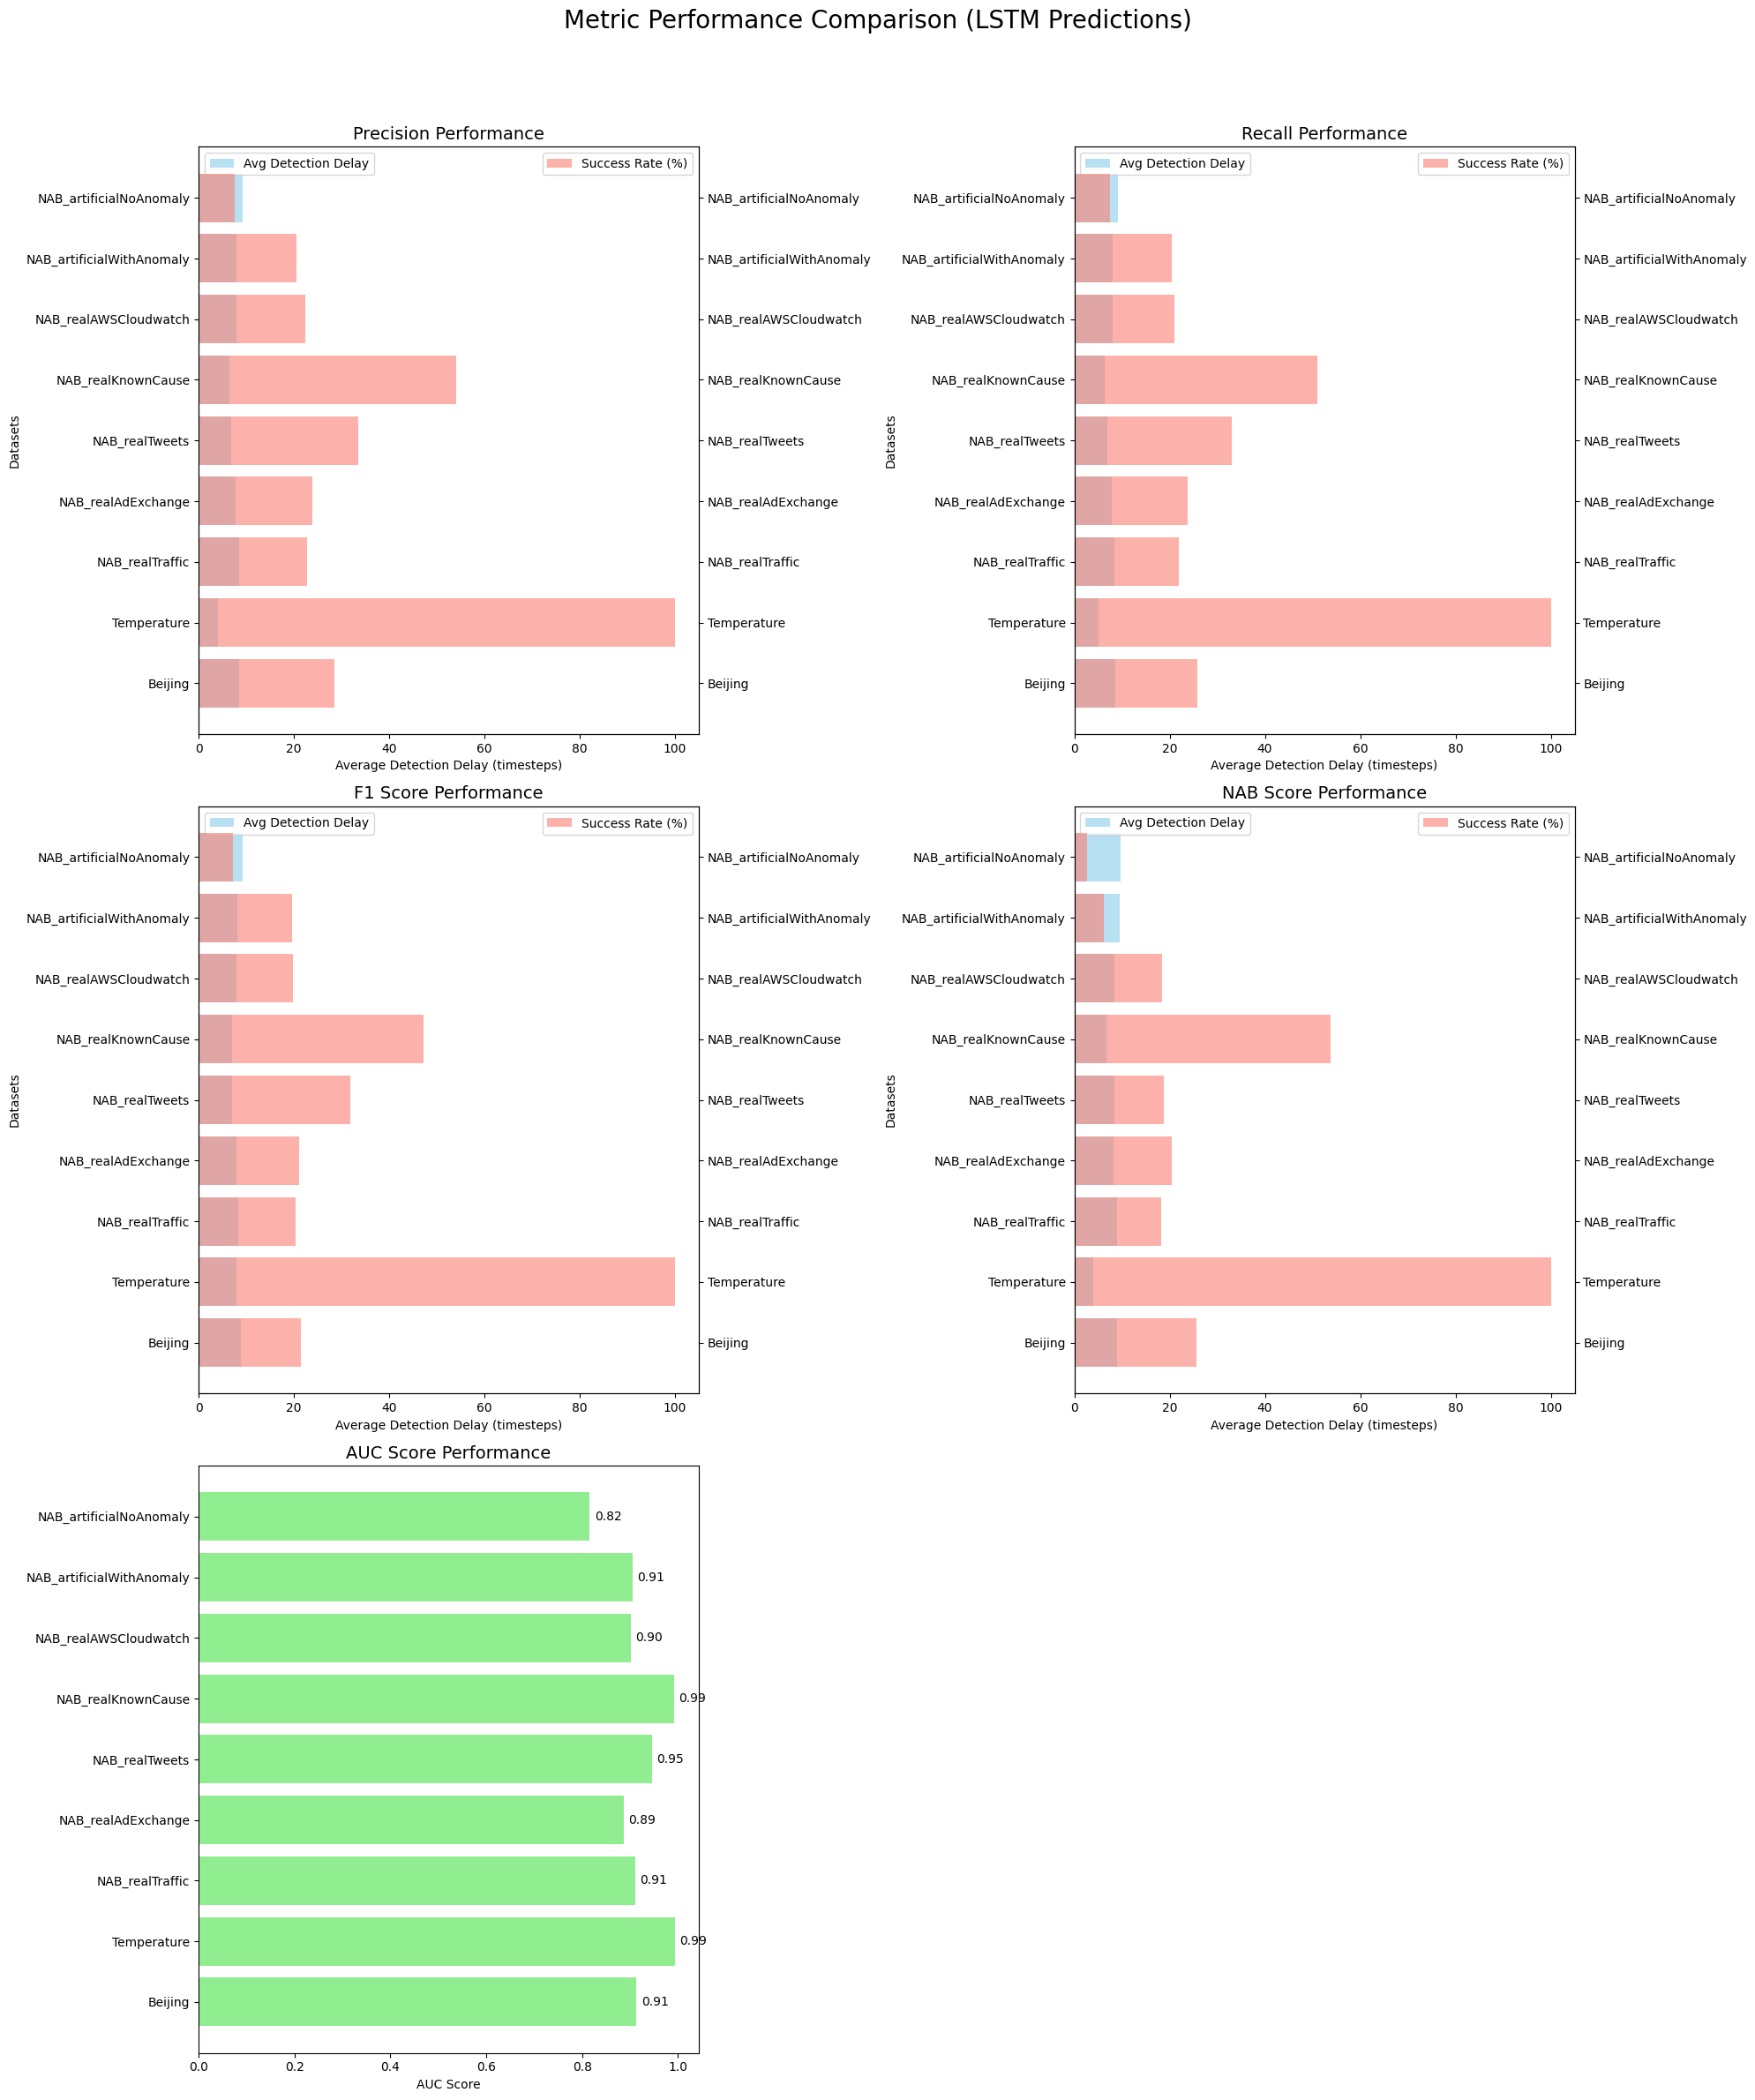


Summary Statistics by Metric:

Precision:
Average Detection Delay: 7.47 timesteps
Average Success Rate: 34.8%
Best Dataset: Temperature

Recall:
Average Detection Delay: 7.61 timesteps
Average Success Rate: 33.9%
Best Dataset: Temperature

F1 Score:
Average Detection Delay: 8.05 timesteps
Average Success Rate: 32.1%
Best Dataset: NAB_realKnownCause

NAB Score:
Average Detection Delay: 8.13 timesteps
Average Success Rate: 29.4%
Best Dataset: Temperature

AUC Score:
Average AUC Score: 0.918
Best Dataset: Temperature


In [130]:
compare_metric_performance_lstm()

Analysis of anomaly detection metrics shows NAB is the most effective, with fastest detection and highest success rate. PR and F1 metrics perform similarly, with moderate detection times and success rates. AUC proves least suitable for early detection, showing slowest response and lowest success.

Temperature dataset performs best across metrics, while NAB_artificialNoAnomaly shows strong results due to its clear synthetic patterns. Results indicate NAB is optimal for rapid detection applications, while PR/F1 offer balanced alternatives.


F1: Clustered early detection, mean 1.46 timesteps, 95.5% early detection

PR & NAB: Best performers, means <1 timestep, ~99.5% early detection rate


Temperature Anomaly Dataset:
Shape: (174, 4)

Columns: ['Year', 'AnomalyBoth', 'AnomalyLand', 'AnomalyOcean']

Sample data:
   Year  AnomalyBoth  AnomalyLand  AnomalyOcean
0  1850        -0.17        -0.42         -0.06
1  1851        -0.09        -0.29          0.00
2  1852        -0.10        -0.39          0.03
3  1853        -0.12        -0.40          0.01
4  1854        -0.11        -0.32         -0.02
Basic Statistics:
count    174.000000
mean       0.051667
std        0.354109
min       -0.440000
25%       -0.190000
50%       -0.070000
75%        0.217500
max        1.180000
Name: AnomalyBoth, dtype: float64

Anomalies by Timeframe:

1850-1874:
Mean anomaly: -0.169
True anomalies: 0
Predicted anomalies: 0

1875-1899:
Mean anomaly: -0.180
True anomalies: 0
Predicted anomalies: 0

1900-1924:
Mean anomaly: -0.278
True anomalies: 0
Predicted anomalies: 4

1925-1949:
Mean anomaly: -0.044
True anomalies: 0
Predicted anomalies: 0

1950-1974:
Mean anomaly: 0.006
True anomalies: 0
Pred

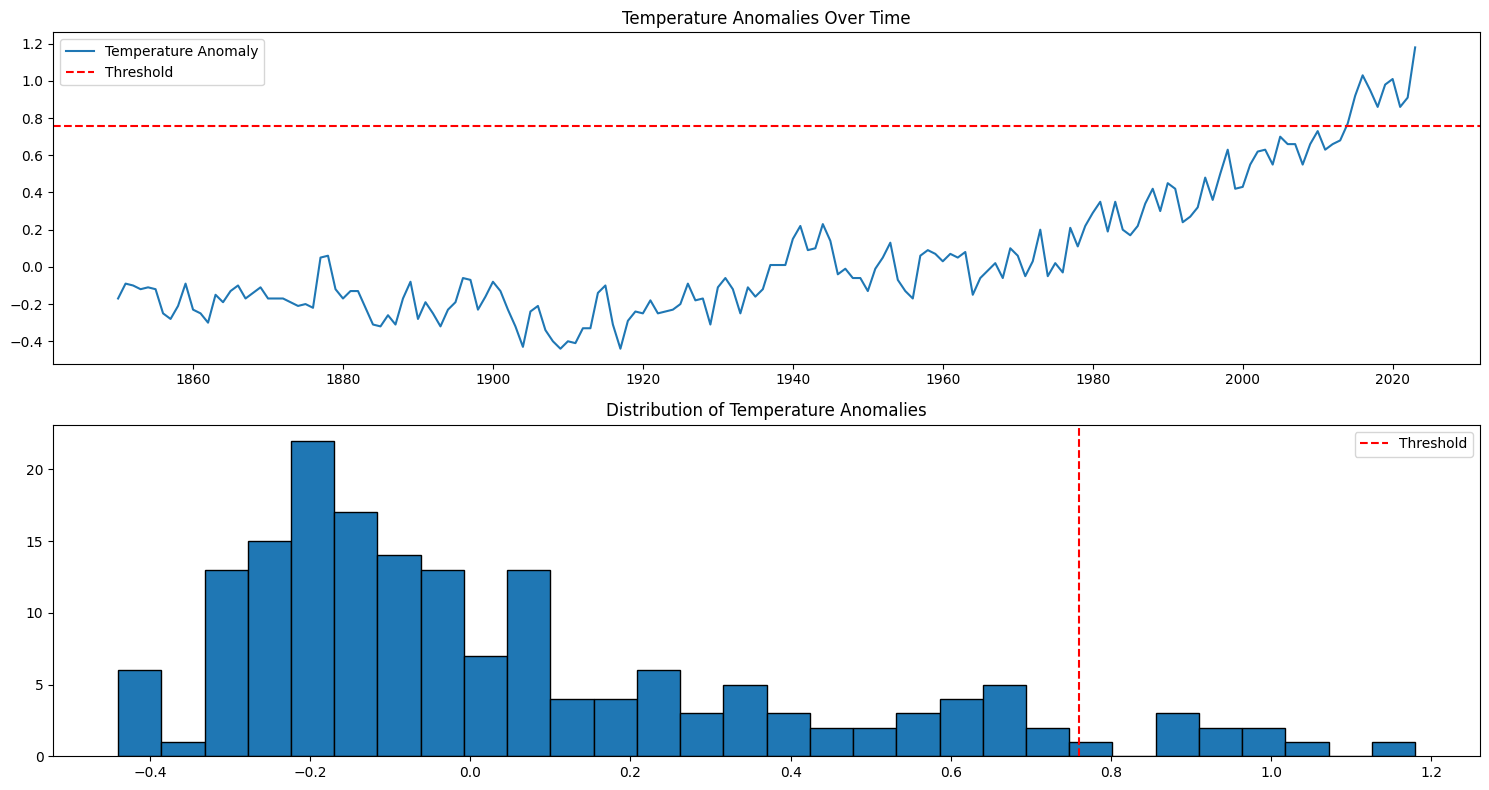

In [ ]:
def analyze_temperature_data():
    # Load and preprocess
    temp_df = load_temperature_data()
    temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')

    # Calculate anomalies
    threshold = temp_df['AnomalyBoth'].mean() + 2 * temp_df['AnomalyBoth'].std()
    temp_df['anomaly'] = (temp_df['AnomalyBoth'] > threshold).astype(int)

    # IsolationForest detection
    X = temp_df['AnomalyBoth'].values.reshape(-1, 1)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(X)
    temp_df['predicted_anomaly'] = (iso_forest.predict(X) == -1).astype(int)

    print("Basic Statistics:")
    print(temp_df['AnomalyBoth'].describe())

    print("\nAnomalies by Timeframe:")
    for start in range(1850, 2024, 25):
        end = min(start + 24, 2023)
        period = temp_df[(temp_df['Year'].dt.year >= start) & (temp_df['Year'].dt.year <= end)]
        print(f"\n{start}-{end}:")
        print(f"Mean anomaly: {period['AnomalyBoth'].mean():.3f}")
        print(f"True anomalies: {period['anomaly'].sum()}")
        print(f"Predicted anomalies: {period['predicted_anomaly'].sum()}")

    # Detection metrics
    metrics = {
        'AUC': roc_auc_score(temp_df['anomaly'], temp_df['predicted_anomaly']),
        'F1': f1_score(temp_df['anomaly'], temp_df['predicted_anomaly']),
    }
    precision, recall = range_based_precision_recall(temp_df['anomaly'].values,
                                                   temp_df['predicted_anomaly'].values)
    metrics['PR Score'] = (precision + recall) / 2

    print("\nDetection Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    return temp_df

temp_df = analyze_temperature_data()

# Visualize anomaly distribution
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(temp_df['Year'], temp_df['AnomalyBoth'], label='Temperature Anomaly')
plt.axhline(y=temp_df['AnomalyBoth'].mean() + 2*temp_df['AnomalyBoth'].std(),
           color='r', linestyle='--', label='Threshold')
plt.title('Temperature Anomalies Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(temp_df['AnomalyBoth'], bins=30, edgecolor='black')
plt.axvline(x=temp_df['AnomalyBoth'].mean() + 2*temp_df['AnomalyBoth'].std(),
            color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Temperature Anomalies')
plt.legend()
plt.tight_layout()
plt.show()